# __*LINEAR REGRESSION MODEL*__

## __*IMPORT LIBRARIES*__

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score,KFold,LeaveOneOut
from sklearn.metrics import r2_score,mean_absolute_error,root_mean_squared_error,mean_squared_error

import seaborn as sns

import matplotlib.pyplot as plt
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LinearRegression, Lasso, LassoCV
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm
import statsmodels.formula.api as smf

from statsmodels.tools.eval_measures import rmse
import statsmodels.formula.api as smf


## __*DATASET*__

In [45]:
data = pd.read_csv('cleaned_data.csv')
data = data.dropna(subset=['marathon_time_in_minutes']) # NOTE: dropping NaN in marathon times 


X_marathon = data[['marathon_time_in_minutes', 'days', 'height','age', 'HRmax', 'weight']]
y_marathon = data[['vo2max','weeklyKM']]

data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 132 entries, 0 to 133
Data columns (total 43 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              132 non-null    float64
 1   Halfmarathon_min                132 non-null    float64
 2   numHalfMarathon                 132 non-null    float64
 3   yearsTrained                    132 non-null    float64
 4   age                             132 non-null    int64  
 5   height                          132 non-null    float64
 6   weight                          132 non-null    float64
 7   bmi                             132 non-null    float64
 8   pbf                             132 non-null    float64
 9   HRmax                           132 non-null    float64
 10  vo2max                          132 non-null    float64
 11  Lactate                         132 non-null    float64
 12  RPE                             132 non-n

## __*HEATMAP*__

Text(0.5, 1.0, 'Correlation Between Variables')

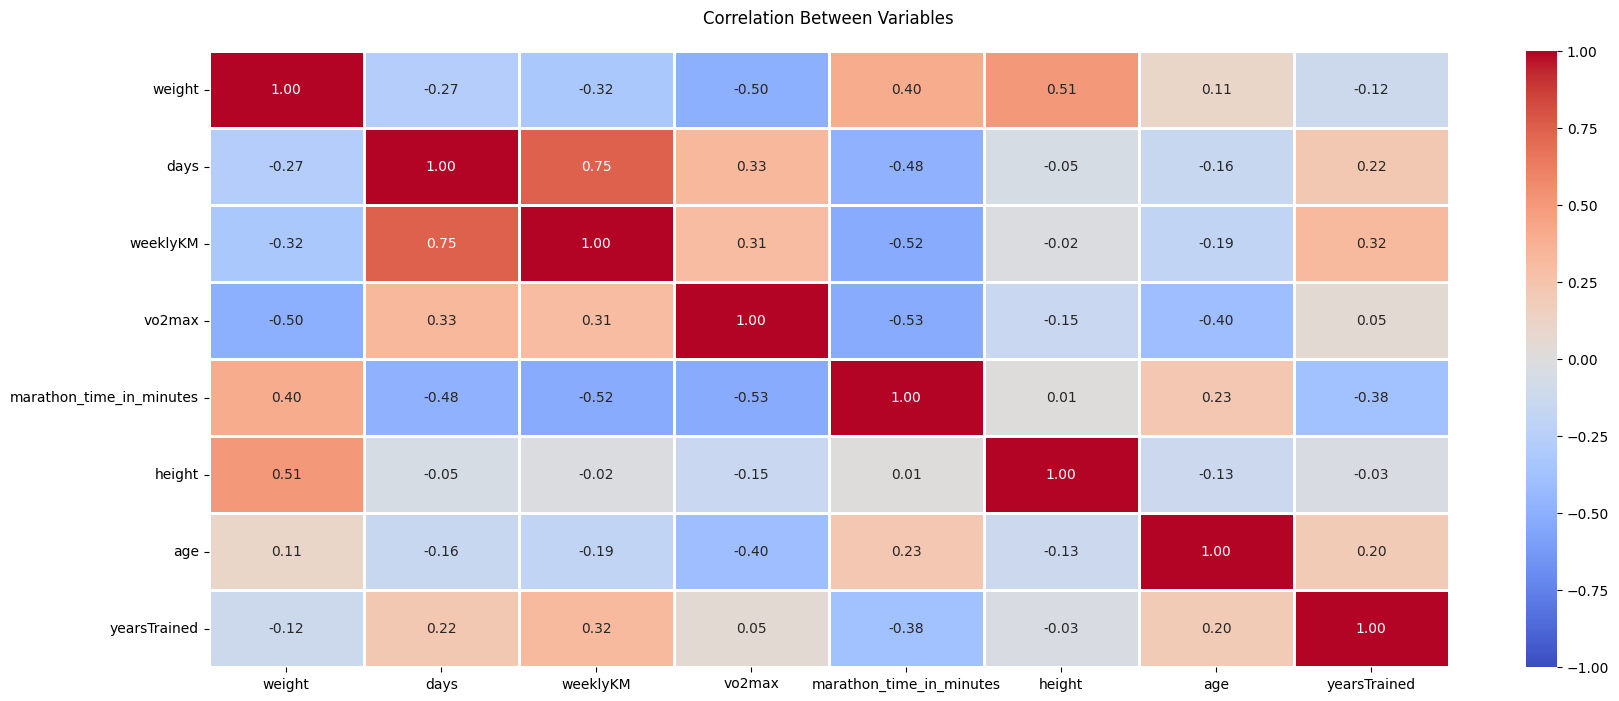

In [5]:
bb = data[['weight', 'days', 'weeklyKM', 'vo2max','marathon_time_in_minutes', 'height', 'age', 'yearsTrained' ]] 
corr = bb.corr()
plt.figure(figsize=(20, 8))  

sns.heatmap(corr, vmin=-1, vmax=1, cmap = 'coolwarm', annot=True, fmt='.2f', linewidths=1)
plt.title("Correlation Between Variables", pad=20)

REMEMBER !!!!  we investigate both negative and posiive influence

## __MULTI-OUTPUT WRAPPER__

In [6]:
def perform_linear_regresson(x, y, seed):
    X_tmp, X_test, y_tmp, y_test = train_test_split(x, y, test_size=0.2, random_state=seed)
    X_train, X_validation, y_train, y_validation = train_test_split(x, y, test_size=0.125, random_state=seed)

    ln = MultiOutputRegressor(LinearRegression())
    ln = ln.fit(X_train, y_train)
    pred = ln.predict(X_validation)

    score = ln.score(X_train, y_train)
    mse = mean_squared_error(y_validation, pred)
    r2_overall = r2_score(y_validation, pred)

    # Individual R^2 scores
    if isinstance(y_validation, np.ndarray):
        r2_individual = [r2_score(y_validation[:, i], pred[:, i]) for i in range(y_validation.shape[1])]
    else:
        r2_individual = [r2_score(y_validation.iloc[:, i], pred[:, i]) for i in range(y_validation.shape[1])]

    coeff = [estimator.coef_ for estimator in ln.estimators_]

    return ln, mse, r2_overall, r2_individual, y_validation, pred, score, coeff

In [7]:
ln_42, mse, r2_overall, r2_individual, y_test, pred, score, coeff = perform_linear_regresson(X_marathon, y_marathon, 42)

print(f'MSE: {mse}')
print(f'Overall R2: {r2_overall}')
print(f'Training Score: {score}')

for i, r2 in enumerate(r2_individual):
    print(f'R2 for target {i}: {r2}')


MSE: 235.37791034335132
Overall R2: 0.23358114104138966
Training Score: 0.5881421112368694
R2 for target 0: 0.18182189617637246
R2 for target 1: 0.28534038590640687


In [8]:
ln, mse, r2_overall, r2_individual, y_test, pred, score, coeff = perform_linear_regresson(X_marathon, y_marathon,20)

print(f'MSE: {mse}')
print(f'Overall R2: {r2_overall}')
print(f'Training Score: {score}')

for i, r2 in enumerate(r2_individual):
    print(f'R2 for target {i}: {r2}')

MSE: 130.0828699156557
Overall R2: 0.5250637465295117
Training Score: 0.5307722076351857
R2 for target 0: 0.6440159794742975
R2 for target 1: 0.40611151358472597


In [9]:
ln, mse, r2_overall, r2_individual, y_test, pred, score, coeff = perform_linear_regresson(X_marathon, y_marathon, 35)

print(f'MSE: {mse}')
print(f'Overall R2: {r2_overall}')
print(f'Training Score: {score}')

for i, r2 in enumerate(r2_individual):
    print(f'R2 for target {i}: {r2}')

MSE: 96.64100844877257
Overall R2: 0.442815432994289
Training Score: 0.5499559420799272
R2 for target 0: 0.6243252218738634
R2 for target 1: 0.2613056441147146


### __TEST SET PERFORMANCE FOR MULTIOUTPUT__

In [10]:
def perform_linear_regresson_test(x, y, seed, ln):
    X_tmp, X_test, y_tmp, y_test = train_test_split(x, y, test_size=0.2, random_state=seed)
    X_train, X_validation, y_train, y_validation = train_test_split(x, y, test_size=0.125, random_state=seed)

    pred = ln.predict(X_test)

    score = ln.score(X_test, y_test)
    mse = mean_squared_error(y_test, pred)
    r2_overall = r2_score(y_test, pred)

    # Individual R^2 scores
    if isinstance(y_test, np.ndarray):
        r2_individual = [r2_score(y_test[:, i], pred[:, i]) for i in range(y_test.shape[1])]
    else:
        r2_individual = [r2_score(y_test.iloc[:, i], pred[:, i]) for i in range(y_test.shape[1])]

    coeff = [estimator.coef_ for estimator in ln.estimators_]

    return ln, mse, r2_overall, r2_individual, y_test, pred, score, coeff

In [11]:
ln, mse, r2_overall, r2_individual, y_test, pred, score, coeff = perform_linear_regresson_test(X_marathon, y_marathon, 35, ln_42)

print(f'MSE: {mse}')
print(f'Overall R2: {r2_overall}')
print(f': {score}')

for i, r2 in enumerate(r2_individual):
    print(f'R2 for target {i}: {r2}')

for i in range(len(y_test)):
    true_vals = ", ".join([f"{v:.4f}" for v in y_test.iloc[i].values])
    pred_vals = ", ".join([f"{v:.4f}" for v in pred[i]])
    print(f"Sample {i+1} - True: [{true_vals}] \t Predicted: [{pred_vals}]")

MSE: 102.58417505088588
Overall R2: 0.5538491681105997
: 0.5538491681105997
R2 for target 0: 0.6396906555819419
R2 for target 1: 0.4680076806392576
Sample 1 - True: [95.0000, 51.3000] 	 Predicted: [86.7467, 56.3201]
Sample 2 - True: [45.0000, 50.9000] 	 Predicted: [60.8538, 46.4506]
Sample 3 - True: [65.0000, 61.8000] 	 Predicted: [69.6888, 56.7593]
Sample 4 - True: [80.0000, 64.7000] 	 Predicted: [69.3682, 53.6815]
Sample 5 - True: [55.0000, 43.6000] 	 Predicted: [51.6703, 46.8188]
Sample 6 - True: [70.0000, 37.5000] 	 Predicted: [75.7012, 45.3920]
Sample 7 - True: [65.0000, 47.7000] 	 Predicted: [55.4048, 49.7855]
Sample 8 - True: [32.5000, 33.2000] 	 Predicted: [42.3619, 45.1695]
Sample 9 - True: [50.0000, 50.7000] 	 Predicted: [46.6004, 39.0778]
Sample 10 - True: [80.0000, 51.6000] 	 Predicted: [66.9306, 51.9908]
Sample 11 - True: [45.0000, 37.5000] 	 Predicted: [25.0382, 48.1105]
Sample 12 - True: [110.0000, 48.0000] 	 Predicted: [93.9519, 51.2580]
Sample 13 - True: [75.0000, 50.6

## __*OLS LINEAR REGRESSION INVESTIGATION*__

### __PREDICT EACH MULTI-OUTPUT REALIZATION SEPARETLY - multi step linear regression__

In [70]:
data_ols = data[['marathon_time_in_minutes', 'height', 'age', 'yearsTrained', 'weight', 'days', 'weeklyKM', 'vo2max', 'Halfmarathon_min', 'FFM', 'HRmax', 'bmi']]

tmp_42, test_42 = train_test_split(data_ols, test_size=0.2, random_state=42)
train_42, validation_42 = train_test_split(tmp_42, test_size=0.125, random_state=42)


models_seed_42 = []
for i,col in enumerate(y_marathon):
    model = smf.ols(f"{col} ~ marathon_time_in_minutes + height + age + HRmax + days + weight", data=train_42).fit()
    models_seed_42.append(model)

In [71]:
data_ols = data[['marathon_time_in_minutes', 'height', 'age', 'yearsTrained', 'weight', 'days', 'weeklyKM', 'vo2max', 'Halfmarathon_min', 'FFM', 'HRmax', 'bmi']]

tmp_20, test_20 = train_test_split(data_ols, test_size=0.2, random_state=20)
train_20, validation_20 = train_test_split(tmp_20, test_size=0.125, random_state=20)

models_seed_20 = []
for i,col in enumerate(y_marathon):
    model = smf.ols(f"{col} ~ marathon_time_in_minutes + height + age + HRmax + days + weight", data=train_20).fit()
    models_seed_20.append(model)

In [72]:
data_ols = data[['marathon_time_in_minutes', 'height', 'age', 'yearsTrained', 'weight', 'days', 'weeklyKM', 'vo2max', 'Halfmarathon_min', 'FFM', 'HRmax', 'bmi']]

tmp_35, test_35 = train_test_split(data_ols, test_size=0.2, random_state=35)
train_35, validation_35 = train_test_split(tmp_35, test_size=0.125, random_state=35)

models_seed_35 = []
for i,col in enumerate(y_marathon):
    model = smf.ols(f"{col} ~ marathon_time_in_minutes + height + age + HRmax + days + weight", data=train_35).fit()
    models_seed_35.append(model)

### __K-FOLD FUNCTION__

**K-FOLD:** 

- Splits datarandomly given shuffle=True, completely ignores the distribution, 
- May result inimblanced class proportions in each fold
 

In [15]:
def compute_K_fold(X,y,splits):
    scores=[] 
    rmse_list=[]
    lrmodel = LinearRegression()
    cv = KFold(n_splits=splits, random_state=42, shuffle=True)
    for train_index, test_index in cv.split(X):
        X_train, X_test, y_train, y_test = X.iloc[train_index], X.iloc[test_index], y.iloc[train_index], y.iloc[test_index]
        lrmodel.fit(X_train, y_train)
        y_predict = lrmodel.predict(X_test)
        scores.append(lrmodel.score(X_test, y_test))
        rmse_fold = rmse(y_test, y_predict)
        rmse_list.append(rmse_fold)

    return scores,rmse_list

### __LEAVE ONE OUT FUNCTION__

In [16]:
def compute_loo_fold(X,y):
    rmse_list=[]
    lrmodel = LinearRegression()
    loo = LeaveOneOut()
    for train_index, test_index in loo.split(X):
        X_train, X_test, y_train, y_test = X.iloc[train_index], X.iloc[test_index], y.iloc[train_index], y.iloc[test_index]
        lrmodel.fit(X_train, y_train)
        y_predict = lrmodel.predict(X_test)
        rmse_fold = rmse(y_test, y_predict)
        rmse_list.append(rmse_fold)

    return rmse_list

### 
__INTRODUCTION FOR THE ANALYSIS__

The P-value is used to conclude if there is any relationship between the predictor and the realization :

-  A low value P < 0.05 means that coefficint beta associated to that varible is not equal to zero hence the varible is influencing the outcome
- A high P > 0.05 means that we caanot confidently say that this variable is affecting the outcome

The thresold 0.05 is associated to the rejection of the null hypothesis where we state that the null hypoesis is __Wrongly__ rejected 5% of the time 

If the P value is for example a high percentage, we coclude that with that percentage the coefficient couldbe 0, hence not influencing 

#### __INVESTIGATE Y REALIZATIONS SINGULARLY - multi step__                                       

##### __WEEKLYKM -- as realization__

In [73]:
print(f'model summary for value {models_seed_42[1].model.endog_names} \n \n {models_seed_42[1].summary()}')
print(f'model summary for value {models_seed_20[1].model.endog_names} \n \n {models_seed_20[1].summary()}')
print(f'model summary for value {models_seed_35[1].model.endog_names} \n \n {models_seed_35[1].summary()}')

model summary for value weeklyKM 
 
                             OLS Regression Results                            
Dep. Variable:               weeklyKM   R-squared:                       0.646
Model:                            OLS   Adj. R-squared:                  0.621
Method:                 Least Squares   F-statistic:                     25.58
Date:                Sun, 01 Jun 2025   Prob (F-statistic):           4.50e-17
Time:                        09:32:21   Log-Likelihood:                -356.24
No. Observations:                  91   AIC:                             726.5
Df Residuals:                      84   BIC:                             744.1
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------

In [74]:
ppp_42 = models_seed_42[1].predict(test_42)
weeklyKM_r_42 = r2_score(test_42["weeklyKM"], ppp_42)
print("Test weeklyKM R² (generalization):", weeklyKM_r_42)

ppp_20 = models_seed_20[1].predict(test_20)
weeklyKM_r_20 = r2_score(test_20["weeklyKM"],ppp_20)
print("Test weeklyKM R² (generalization):", weeklyKM_r_20)

ppp_35 = models_seed_35[1].predict(test_35)
weeklyKM_r_35 = r2_score(test_35["weeklyKM"], ppp_35)
print("Test weeklyKM R² (generalization):",weeklyKM_r_35)

Test weeklyKM R² (generalization): 0.44376410576565395
Test weeklyKM R² (generalization): 0.7259596131913602
Test weeklyKM R² (generalization): 0.44130252057494157


__KFOLD WEEKLYKM CHECK__

In [75]:
X = data[['marathon_time_in_minutes', 'age',  "HRmax" ,"days", "FFM", "bmi"]]
y = data[['weeklyKM']]
r2_scores_ten,rmses_ten = compute_K_fold(X,y,10)
r2_scores_five,rmses_five = compute_K_fold(X,y,5)

print(f"R2 Squared Mean -> 10 folds: {np.mean(r2_scores_ten)} vs 5 folds: {np.mean(r2_scores_five)} ")
print(f"RMSE -> 10 folds: {np.mean(rmses_ten)} vs 5 folds: {np.mean(rmses_five)} ")

R2 Squared Mean -> 10 folds: 0.4066824302456579 vs 5 folds: 0.4785800821402745 
RMSE -> 10 folds: 13.920846080006859 vs 5 folds: 14.065914129921378 


In this case yearsTrained has a low P-value but not lower than 0.05 which means that we would have a higher chance of wrongly rejecting the null hypothesis, though compared to height and age, it seems resonable that someone that has been training for longer time then could run more km weekly

R2 on unseen data is negative which is not good at all.

 __LEAVE ONE OUT WEEKLYKM CHECK__ 

In [76]:
X = data[['marathon_time_in_minutes', 'age',  "HRmax" ,"days", "FFM", "bmi"]]
y = data[['weeklyKM']]
rmses= compute_loo_fold(X,y)

print(f"RMSE MEAN : {np.mean(rmses)}\n")
for i,r in enumerate(rmses):
    print(f"Fold nr {i+1} differed by {r}")

RMSE MEAN : 10.084615882305856

Fold nr 1 differed by [13.27570392]
Fold nr 2 differed by [30.55612385]
Fold nr 3 differed by [21.2640345]
Fold nr 4 differed by [5.804611]
Fold nr 5 differed by [56.69365195]
Fold nr 6 differed by [10.45816818]
Fold nr 7 differed by [20.66308429]
Fold nr 8 differed by [11.9688681]
Fold nr 9 differed by [7.02766147]
Fold nr 10 differed by [17.29713108]
Fold nr 11 differed by [11.98142166]
Fold nr 12 differed by [4.71640523]
Fold nr 13 differed by [1.6857549]
Fold nr 14 differed by [17.46625304]
Fold nr 15 differed by [7.94432888]
Fold nr 16 differed by [2.86985519]
Fold nr 17 differed by [12.00767866]
Fold nr 18 differed by [9.17263341]
Fold nr 19 differed by [11.43286593]
Fold nr 20 differed by [6.73402316]
Fold nr 21 differed by [6.26987579]
Fold nr 22 differed by [9.61327224]
Fold nr 23 differed by [14.74008136]
Fold nr 24 differed by [5.86797191]
Fold nr 25 differed by [2.74750294]
Fold nr 26 differed by [10.43347009]
Fold nr 27 differed by [13.95178

##### __VO2MAX -- as realization__

In [77]:
print(f'model summary for value {models_seed_42[0].model.endog_names} \n \n {models_seed_42[0].summary()}')
print(f'model summary for value {models_seed_20[0].model.endog_names} \n \n {models_seed_20[0].summary()}')
print(f'model summary for value {models_seed_35[0].model.endog_names} \n \n {models_seed_35[0].summary()}')

model summary for value vo2max 
 
                             OLS Regression Results                            
Dep. Variable:                 vo2max   R-squared:                       0.447
Model:                            OLS   Adj. R-squared:                  0.407
Method:                 Least Squares   F-statistic:                     11.30
Date:                Sun, 01 Jun 2025   Prob (F-statistic):           3.20e-09
Time:                        09:32:23   Log-Likelihood:                -286.79
No. Observations:                  91   AIC:                             587.6
Df Residuals:                      84   BIC:                             605.2
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------

Text(0, 1, '                            OLS Regression Results                            \n==============================================================================\nDep. Variable:                 vo2max   R-squared:                       0.447\nModel:                            OLS   Adj. R-squared:                  0.407\nMethod:                 Least Squares   F-statistic:                     11.30\nDate:                Sun, 01 Jun 2025   Prob (F-statistic):           3.20e-09\nTime:                        09:32:23   Log-Likelihood:                -286.79\nNo. Observations:                  91   AIC:                             587.6\nDf Residuals:                      84   BIC:                             605.2\nDf Model:                           6                                         \nCovariance Type:            nonrobust                                         \n============================================================================================\n              

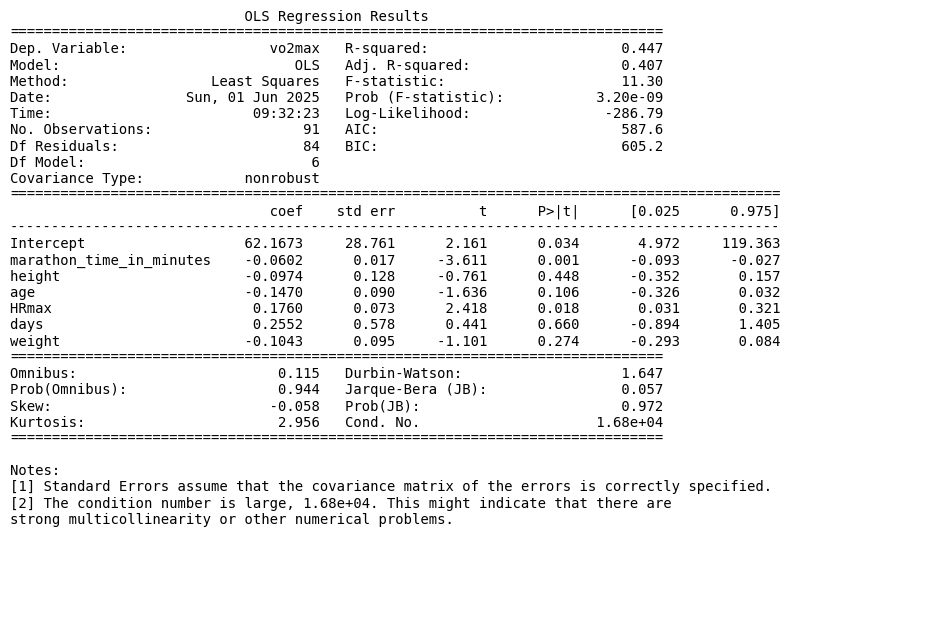

In [78]:
summary_str = models_seed_42[0].summary().as_text()

# Create a figure
fig, ax = plt.subplots(figsize=(12, 8))
ax.axis('off')  # Turn off axes
ax.text(0, 1, summary_str, fontsize=10, va='top', family='monospace')

Halfmarathon min raises a lot the r2 squared for the model

In [79]:
pppp_42 = models_seed_42[0].predict(test_42)
vo2max_r_42 = r2_score(test_42["vo2max"], pppp_42)
print("Test vo2max R² (generalization):",vo2max_r_42 )

pppp_20 = models_seed_20[0].predict(test_20)
vo2max_r_20 = r2_score(test_20["vo2max"], pppp_20)
print("Test vo2max R² (generalization):", r2_score(test_20["vo2max"], pppp_20))

pppp_35 = models_seed_35[0].predict(test_35)
vo2max_r_35 = r2_score(test_35["vo2max"], pppp_35)
print("Test vo2max R² (generalization):", r2_score(test_35["vo2max"], pppp_35))

Test vo2max R² (generalization): 0.45763342650756256
Test vo2max R² (generalization): 0.38966875385210387
Test vo2max R² (generalization): 0.4343733733720553


As already discussed in EDA, as age increases, vo2max is lower and linear regression is fully able to get that and recognises that age has a very high impact on vo2max. Given this it makes sense to have age as a predictor in order to be able to influence the vo2max prediction. 

- Moreover is to investigate the effect that vo2max has on marathon time. 

R2 is negative on unseen data which means it is not very good!!

__K_FOLD VO2MAX CHECK__

In [80]:
X = data[['marathon_time_in_minutes', 'height', 'age',  "HRmax" ,"days" , "Halfmarathon_min",  "FFM" ]]
y = data[['vo2max']]
r2_scores_ten,rmses_ten = compute_K_fold(X,y,10)
r2_scores_five,rmses_five = compute_K_fold(X,y,5)


print(f"R2 Squared Mean -> 10 folds: {np.mean(r2_scores_ten)} vs 5 folds: {np.mean(r2_scores_five)} ")
print(f"RMSE -> 10 folds: {np.mean(rmses_ten)} vs 5 folds: {np.mean(rmses_five)} ")

R2 Squared Mean -> 10 folds: 0.32559867039504037 vs 5 folds: 0.35244640122040044 
RMSE -> 10 folds: 6.057083722777623 vs 5 folds: 6.240413744513802 


__LEAVE ONE OUT VO2MAX CHECK__

In [81]:
X = data[['marathon_time_in_minutes', 'height', 'age',  "HRmax" ,"days" , "Halfmarathon_min",  "FFM" ]]
y = data[['vo2max']]
rmses= compute_loo_fold(X,y)

print(f"RMSE MEAN : {np.mean(rmses)}\n")
for i,r in enumerate(rmses):
    print(f"Fold nr {i+1} differed by {r}")

RMSE MEAN : 4.989084316011651

Fold nr 1 differed by [2.15273119]
Fold nr 2 differed by [12.01535042]
Fold nr 3 differed by [6.09788653]
Fold nr 4 differed by [9.30915529]
Fold nr 5 differed by [1.47912453]
Fold nr 6 differed by [1.43085479]
Fold nr 7 differed by [0.26684907]
Fold nr 8 differed by [11.91937537]
Fold nr 9 differed by [7.33695009]
Fold nr 10 differed by [3.3423929]
Fold nr 11 differed by [12.48976685]
Fold nr 12 differed by [8.27785865]
Fold nr 13 differed by [5.35283237]
Fold nr 14 differed by [2.97053262]
Fold nr 15 differed by [3.21631313]
Fold nr 16 differed by [2.74058202]
Fold nr 17 differed by [2.81330124]
Fold nr 18 differed by [4.01438345]
Fold nr 19 differed by [2.7971252]
Fold nr 20 differed by [2.21774026]
Fold nr 21 differed by [14.75170439]
Fold nr 22 differed by [6.23288754]
Fold nr 23 differed by [0.76998646]
Fold nr 24 differed by [3.29173124]
Fold nr 25 differed by [1.99782712]
Fold nr 26 differed by [4.79628577]
Fold nr 27 differed by [3.66894037]
Fold

### __Average TEST performance of weekly and vo2__

##### __HISTOGRAMS__

In [28]:
def plot_histogram_single_features(usr_input,title,y_axis,x_axis):
    # Feature names and their corresponding "realization" values
    features = list(usr_input.keys())
    values = [] 
    for i,ft in enumerate(features):
        values.append(usr_input[ft])


    # Plotting
    plt.figure(figsize=(8, 5))
    bars = plt.bar(features, values, color='skyblue', edgecolor='black')

    # Add value labels on top of each bar
    for bar, importance in zip(bars, values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                 f'{importance:.2f}', ha='center', va='bottom', fontsize=10)

    plt.title(f'{title}', fontsize=14)
    plt.ylabel(y_axis)
    plt.xlabel(x_axis)

    mx = 0
    for val in values:
        if val > mx :
            mx = val

    plt.ylim(0, mx + 10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

In [29]:
# converts marathon times from minutes to hr.mm
def convert_marathon_time(time):
    rest = 0
    while(time % 60 != 0):
        rest += 1
        time -= 1
    return str(time//60) + str(rest)

# performs actual prediction and returns an object with the realizations values
def run_trial(user_input,regressor,realization):
    user_input_df = pd.DataFrame([user_input])
    predictions = regressor.predict(user_input_df)

    realizations_obj = {
        'time': convert_marathon_time(user_input["marathon_time_in_minutes"]),
    }
    realizations_obj[realization] = predictions[0] 
    
    return realizations_obj


def construct_user (time,height,age,yearsTrained) :
    user = {
        'marathon_time_in_minutes': time,
        'height' : height,
        'age' : age,
        'yearsTrained' : yearsTrained,
    }
    return user

# NOTE: users is a list of prdiction objects
def construct_single_feature_user(pred,y):
    realization = {}
    times = ['five', 'four_t', 'four', 'three_t', 'three', 'two_f']
    
    # NOTE: a prediction user is an object with weight,days,weeklyKM,vo2max
    for i,p in enumerate(pred):
        realization[times[i]]=p[y]

    return realization

# NOTE: returns a list of prediction objects
def make_trials(regressor,times, unchanged, realization):
    trials = []
    for i,time in enumerate(times):
        # NOTE: CALLING run_trial, hence returning prediction objects
        res = run_trial(construct_user(time, **unchanged), regressor,realization)
        trials.append(res)
    return trials

In [30]:
# NOTE!! this are unchanged because we need to test results for different times but same metrics to see if actually methods performs
unchanged = {
    'height' : 174,
    'age' : 36,
    'yearsTrained' : 24,
}
# prediction_arr = list(construct_single_feature_user(make_trials(models[0],[300,270,240,210,180,160],unchanged)))

# for i,pred_elem in enumerate(prediction_arr):
#     title = ['weight']
#     plot_histogram_single_features(pred_elem, f'EXTRA TREE - {title[i]}', title[i],'Marathon Times')

prediction_obj1 = construct_single_feature_user(
    make_trials(models[0], [300, 270, 240, 210, 180, 160], unchanged, 'weight'),
    'weight'
)
prediction_obj2 = construct_single_feature_user(
    make_trials(models[1], [300, 270, 240, 210, 180, 160], unchanged, 'days'), 
    'days'
)
prediction_obj3 = construct_single_feature_user(
    make_trials(models[2], [300, 270, 240, 210, 180, 160], unchanged, 'weeklyKM'), 
    'weeklyKM'
)
prediction_obj4 = construct_single_feature_user(
    make_trials(models[3], [300, 270, 240, 210, 180, 160], unchanged, 'vo2max'), 
    'vo2max'
)

# plot histogram for weight prediction across marathon times
plot_histogram_single_features(prediction_obj1, 'LINEAR REGRESSION - weight','weight','Marathon Times')
plot_histogram_single_features(prediction_obj2, 'LINEAR REGRESSION - days','days','Marathon Times')
plot_histogram_single_features(prediction_obj3, 'LINEAR REGRESSION - weeklyKM','weeklyKM','Marathon Times')
plot_histogram_single_features(prediction_obj4, 'LINEAR REGRESSION - vo2max','vo2max','Marathon Times')

NameError: name 'models' is not defined

#### __USE Y REALIZATIONS AS PREDICTORS FOR marathon_time_in_minutes__ 

##### __All predictors against marathon_time__

In [17]:
def perform_linear_on_marathon_time(seed):
    X_marathon = data[['weight','weeklyKM','vo2max' ]]
    train_tmp, test_tmp = train_test_split(data_ols, test_size=0.2, random_state=seed)
    train, validation = train_test_split(train_tmp, test_size=0.125, random_state=seed)
    model_all = smf.ols(f"marathon_time_in_minutes ~ weight + weeklyKM + vo2max", data=train).fit()
    return model_all,validation

In [18]:
seed=42
model_all_42,validation_42 = perform_linear_on_marathon_time(seed)

X_val = validation_42[['weight', 'weeklyKM', 'vo2max']]
y_val = validation_42[['marathon_time_in_minutes']]
print(model_all_42.summary(), '\n')

# NOTE: validating
pred = model_all_42.predict(validation_42)
print("Test all R² (generalization):", r2_score(y_val, pred))

                               OLS Regression Results                               
Dep. Variable:     marathon_time_in_minutes   R-squared:                       0.471
Model:                                  OLS   Adj. R-squared:                  0.453
Method:                       Least Squares   F-statistic:                     25.82
Date:                      Thu, 29 May 2025   Prob (F-statistic):           4.86e-12
Time:                              18:21:53   Log-Likelihood:                -448.59
No. Observations:                        91   AIC:                             905.2
Df Residuals:                            87   BIC:                             915.2
Df Model:                                 3                                         
Covariance Type:                  nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------

Text(0, 1, '                               OLS Regression Results                               \n====================================================================================\nDep. Variable:     marathon_time_in_minutes   R-squared:                       0.471\nModel:                                  OLS   Adj. R-squared:                  0.453\nMethod:                       Least Squares   F-statistic:                     25.82\nDate:                      Thu, 29 May 2025   Prob (F-statistic):           4.86e-12\nTime:                              18:21:55   Log-Likelihood:                -448.59\nNo. Observations:                        91   AIC:                             905.2\nDf Residuals:                            87   BIC:                             915.2\nDf Model:                                 3                                         \nCovariance Type:                  nonrobust                                         \n==========================================

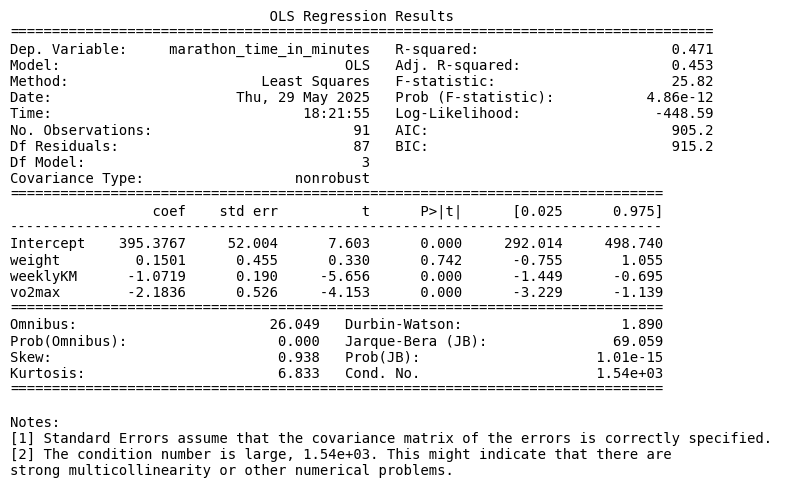

In [19]:
summary_str = model_all_42.summary().as_text()

# Create a figure
fig, ax = plt.subplots(figsize=(10, 6))
ax.axis('off')  # Turn off axes
ax.text(0, 1, summary_str, fontsize=10, va='top', family='monospace')

In [20]:
seed=20
model_all_20,validation_20 = perform_linear_on_marathon_time(seed)

X_val = validation_20[['weight', 'weeklyKM', 'vo2max']]
y_val = validation_20[['marathon_time_in_minutes']]
print(model_all_20.summary(), '\n')

# NOTE: validating
pred = model_all_20.predict(validation_20)
print("Test all R² (generalization):", r2_score(y_val, pred))

                               OLS Regression Results                               
Dep. Variable:     marathon_time_in_minutes   R-squared:                       0.322
Model:                                  OLS   Adj. R-squared:                  0.299
Method:                       Least Squares   F-statistic:                     13.78
Date:                      Thu, 29 May 2025   Prob (F-statistic):           1.98e-07
Time:                              18:21:55   Log-Likelihood:                -456.60
No. Observations:                        91   AIC:                             921.2
Df Residuals:                            87   BIC:                             931.2
Df Model:                                 3                                         
Covariance Type:                  nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------

In [21]:
seed=35
model_all_35,validation_35 = perform_linear_on_marathon_time(seed)

X_val = validation_35[['weight', 'weeklyKM', 'vo2max']]
y_val = validation_35[['marathon_time_in_minutes']]
print(model_all_35.summary(), '\n')

# NOTE: validating
pred = model_all_35.predict(validation_35)
print("Test all R² (generalization):", r2_score(y_val, pred))

                               OLS Regression Results                               
Dep. Variable:     marathon_time_in_minutes   R-squared:                       0.488
Model:                                  OLS   Adj. R-squared:                  0.471
Method:                       Least Squares   F-statistic:                     27.69
Date:                      Thu, 29 May 2025   Prob (F-statistic):           1.16e-12
Time:                              18:21:55   Log-Likelihood:                -437.38
No. Observations:                        91   AIC:                             882.8
Df Residuals:                            87   BIC:                             892.8
Df Model:                                 3                                         
Covariance Type:                  nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------

In [22]:
X = data[['weight', 'weeklyKM' , 'vo2max']]
y = data[['marathon_time_in_minutes']]
r2_scores_ten,rmses_ten = compute_K_fold(X,y,10)
r2_scores_five,rmses_five = compute_K_fold(X,y,5)

print(f"R2 Squared Mean -> 10 folds: {np.mean(r2_scores_ten)} vs 5 folds: {np.mean(r2_scores_five)} ")
print(f"RMSE -> 10 folds: {np.mean(rmses_ten)} vs 5 folds: {np.mean(rmses_five)} ")

R2 Squared Mean -> 10 folds: 0.3117079735917914 vs 5 folds: 0.2985027889652418 
RMSE -> 10 folds: 33.564634646973296 vs 5 folds: 34.842473738310176 


##### __Weight against marathon time__

In [23]:
X = data[['marathon_time_in_minutes', 'weight']]

X_train_weight, y_test_weight = train_test_split(X,test_size=0.2, random_state=42)

model_weight = smf.ols(f" marathon_time_in_minutes ~ weight ", data=X_train_weight).fit()
print(model_weight.summary())

                               OLS Regression Results                               
Dep. Variable:     marathon_time_in_minutes   R-squared:                       0.139
Model:                                  OLS   Adj. R-squared:                  0.131
Method:                       Least Squares   F-statistic:                     16.68
Date:                      Thu, 29 May 2025   Prob (F-statistic):           8.75e-05
Time:                              18:21:57   Log-Likelihood:                -541.70
No. Observations:                       105   AIC:                             1087.
Df Residuals:                           103   BIC:                             1093.
Df Model:                                 1                                         
Covariance Type:                  nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------

In [24]:
pred_weight = model_weight.predict(y_test_weight)
print("Test days R² (generalization):", r2_score(y_test_weight["marathon_time_in_minutes"], pred_weight))

Test days R² (generalization): 0.24745862775547667


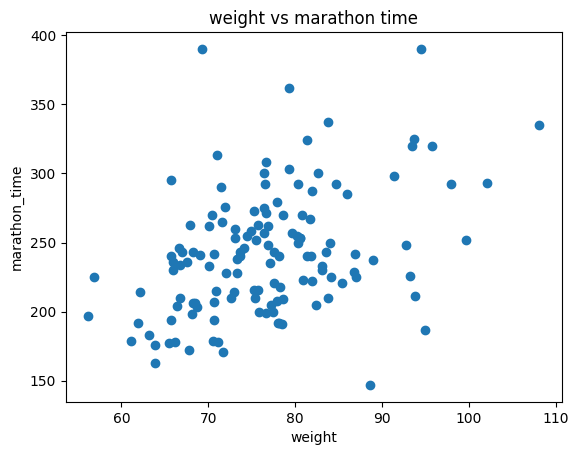

In [25]:
plt.scatter(data['weight'], data['marathon_time_in_minutes'])
plt.title('weight vs marathon time')
plt.xlabel('weight')
plt.ylabel('marathon_time')
plt.show()

##### __weeklyKM against marathon time__

In [36]:
X = data[['marathon_time_in_minutes', 'weeklyKM']]

X_train_week, y_test_week = train_test_split(X,test_size=0.2, random_state=42)

model_weekly = smf.ols(f" marathon_time_in_minutes ~ weeklyKM ", data=X_train_week).fit()
print(model_weekly.summary())

                               OLS Regression Results                               
Dep. Variable:     marathon_time_in_minutes   R-squared:                       0.318
Model:                                  OLS   Adj. R-squared:                  0.312
Method:                       Least Squares   F-statistic:                     48.11
Date:                      Thu, 29 May 2025   Prob (F-statistic):           3.65e-10
Time:                              18:24:06   Log-Likelihood:                -529.47
No. Observations:                       105   AIC:                             1063.
Df Residuals:                           103   BIC:                             1068.
Df Model:                                 1                                         
Covariance Type:                  nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------

Text(0, 1, '                               OLS Regression Results                               \n====================================================================================\nDep. Variable:     marathon_time_in_minutes   R-squared:                       0.318\nModel:                                  OLS   Adj. R-squared:                  0.312\nMethod:                       Least Squares   F-statistic:                     48.11\nDate:                      Thu, 29 May 2025   Prob (F-statistic):           3.65e-10\nTime:                              18:24:08   Log-Likelihood:                -529.47\nNo. Observations:                       105   AIC:                             1063.\nDf Residuals:                           103   BIC:                             1068.\nDf Model:                                 1                                         \nCovariance Type:                  nonrobust                                         \n==========================================

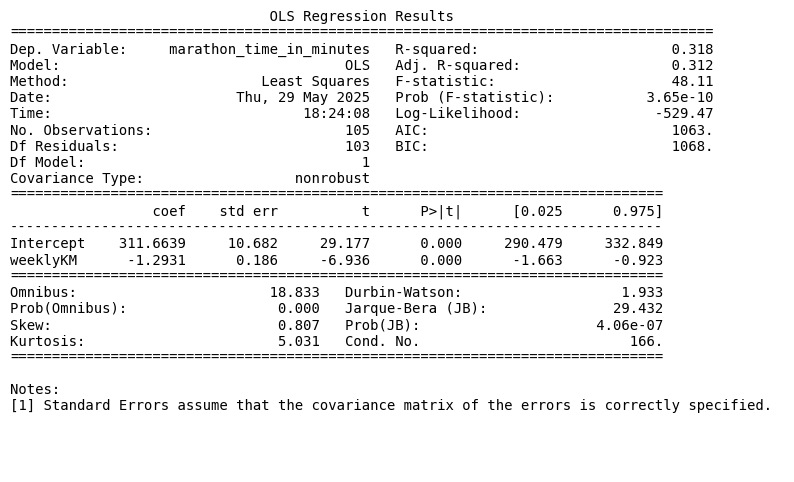

In [37]:
summary_str = model_weekly.summary().as_text()

# Create a figure
fig, ax = plt.subplots(figsize=(10, 6))
ax.axis('off')  # Turn off axes
ax.text(0, 1, summary_str, fontsize=10, va='top', family='monospace')

In [28]:
pred_weekly= model_weekly.predict(y_test_week)
print("Test weeklyKM R² (generalization):", r2_score(y_test_week["marathon_time_in_minutes"], pred_weekly))

Test weeklyKM R² (generalization): 0.04094053630072125


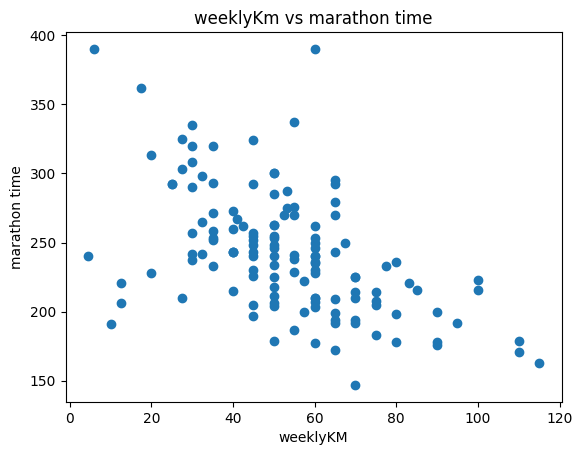

In [29]:
plt.scatter(data['weeklyKM'], data['marathon_time_in_minutes'])
plt.title('weeklyKm vs marathon time')
plt.xlabel('weeklyKM')
plt.ylabel('marathon time')
plt.show()

##### __vo2max against marathon time__

In [38]:
X = data[['marathon_time_in_minutes', 'vo2max']]

X_train_v, y_test_v = train_test_split(X,test_size=0.2, random_state=42)

model_vo2max = smf.ols(f" marathon_time_in_minutes ~ vo2max ", data=X_train_v).fit()
print(model_vo2max.summary())

                               OLS Regression Results                               
Dep. Variable:     marathon_time_in_minutes   R-squared:                       0.269
Model:                                  OLS   Adj. R-squared:                  0.262
Method:                       Least Squares   F-statistic:                     37.87
Date:                      Thu, 29 May 2025   Prob (F-statistic):           1.46e-08
Time:                              18:24:41   Log-Likelihood:                -533.15
No. Observations:                       105   AIC:                             1070.
Df Residuals:                           103   BIC:                             1076.
Df Model:                                 1                                         
Covariance Type:                  nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------

Text(0, 1, '                               OLS Regression Results                               \n====================================================================================\nDep. Variable:     marathon_time_in_minutes   R-squared:                       0.269\nModel:                                  OLS   Adj. R-squared:                  0.262\nMethod:                       Least Squares   F-statistic:                     37.87\nDate:                      Thu, 29 May 2025   Prob (F-statistic):           1.46e-08\nTime:                              18:24:43   Log-Likelihood:                -533.15\nNo. Observations:                       105   AIC:                             1070.\nDf Residuals:                           103   BIC:                             1076.\nDf Model:                                 1                                         \nCovariance Type:                  nonrobust                                         \n==========================================

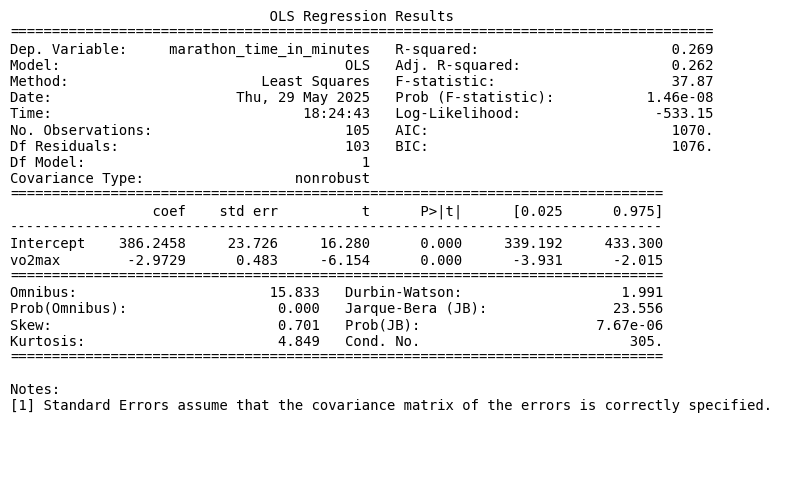

In [39]:
summary_str = model_vo2max.summary().as_text()

# Create a figure
fig, ax = plt.subplots(figsize=(10, 6))
ax.axis('off')  # Turn off axes
ax.text(0, 1, summary_str, fontsize=10, va='top', family='monospace')

In [32]:
pred_vo2max = model_vo2max.predict(y_test_v)
print("Test vo2max R² (generalization):", r2_score(y_test_v["marathon_time_in_minutes"], pred_vo2max))

Test vo2max R² (generalization): 0.33042357211909046


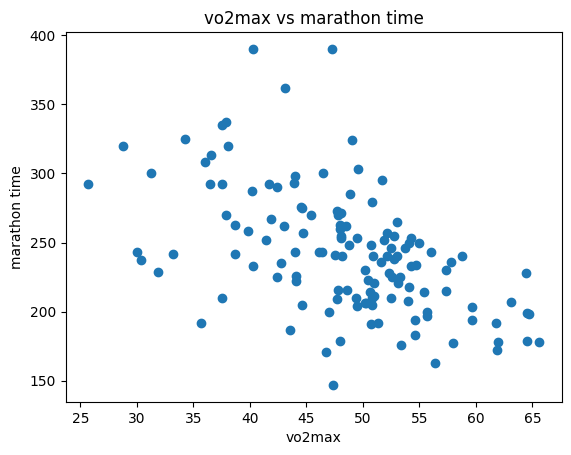

In [33]:
plt.scatter(data['vo2max'], data['marathon_time_in_minutes'])
plt.title('vo2max vs marathon time')
plt.xlabel('vo2max')
plt.ylabel('marathon time')
plt.show()

##### __DEMONSTRATION THAT NOT ALL P-VALUES ARE 0 -- bestSar (best sit and reach)__

In [34]:
data_with_sar = data[['marathon_time_in_minutes', 'bestSar']]

train_with_sar, test_wit_sar = train_test_split(data_with_sar, test_size=0.2, random_state=42)

model = smf.ols(f" marathon_time_in_minutes ~ bestSar ", data=train_with_sar).fit()
print(model.summary())

                               OLS Regression Results                               
Dep. Variable:     marathon_time_in_minutes   R-squared:                       0.001
Model:                                  OLS   Adj. R-squared:                 -0.008
Method:                       Least Squares   F-statistic:                    0.1383
Date:                      Thu, 29 May 2025   Prob (F-statistic):              0.711
Time:                              18:22:02   Log-Likelihood:                -549.52
No. Observations:                       105   AIC:                             1103.
Df Residuals:                           103   BIC:                             1108.
Df Model:                                 1                                         
Covariance Type:                  nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------

###

__ANALYSIS OUTCOME__

Single Predictors all have a P-value = 0.00 which means that they all strongly influence marathon time. 

Our model in facts aims at suggesting runners the best way to reach their desired marathon time, given weight, days, weeklyKM and vo2max as strong influencing predictors of marthon time, retrieving exactly this values from the multioutput tree analysis is the right way of solving the problem.

Every singular predictor is able to explain in between 25% - 30% of overall marathon time variance which for the amount of data that we have is not too bad. All p-values singularly have value = 0.00 which means strong influence.

When the predictors are combined together in predicting marathon time, the overall explained variance is around 40%- 45% which again not bad for the little amount of data that we have. P-values of weight and days are a bit high, around 0.2 which means that when combined with the others they are not as influencing as they are alone in predicting marathon time, still the singular prediction test (using only them singularly to predict the marathon time) tells us they they effectively influence the marathon time. Though evaluating a linear regression simply with weeklyKM and vo2max reaches the same variance explanation which mens we could lower the Y space to just weeklyKM and vo2max.

*TO CONCLUDE*

This analysis tells us that predicting the following parameters is effectively the right way of suggesting a runner the best metrics to improve on in order to reach his desired time. 

Though we need to take into account the fact that this variables (Y predictors) are the ones we are __predicting__ in multioutput trees, hence this metrics are just showing that we are predicting the right indicators for marthon time.

The analysis exemplifies also that when predicting this variables, given the low amount of data we have an r2 squared that is low.

### __MATRIX OF WEIGHTS__

#### __WEIGHTS FOR SEED=42__

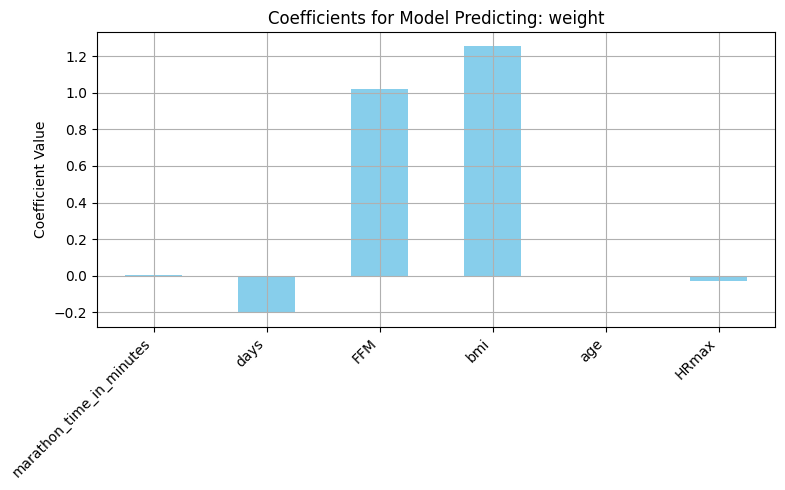

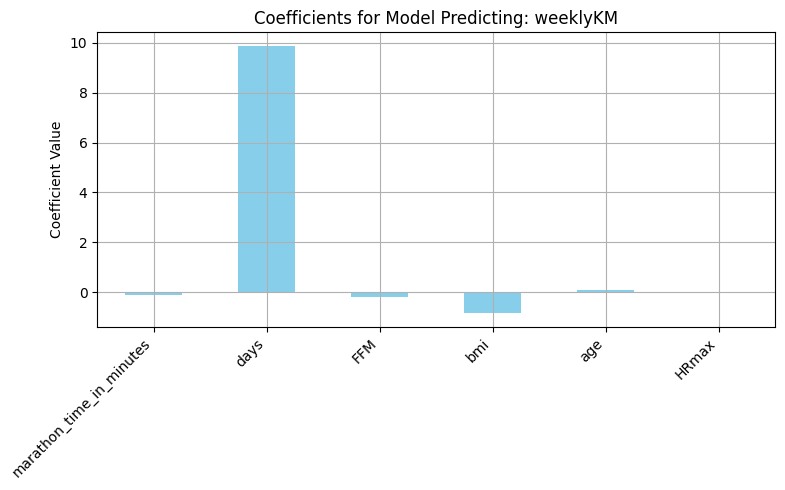

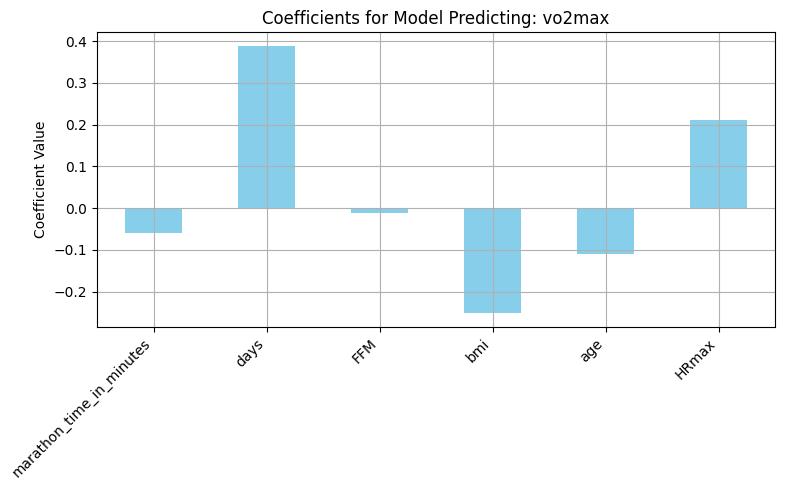

In [ ]:
for target_name, model in zip(y_marathon.columns, models_seed_42):

    coef = model.params.drop(labels='Intercept', errors='ignore')

    plt.figure(figsize=(8, 5))
    coef.plot(kind='bar', color='skyblue')
    plt.title(f"Coefficients for Model Predicting: {target_name}")
    plt.ylabel("Coefficient Value")
    plt.xticks(rotation=45, ha='right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

#### __WEIGHTS FOR SEED=20__

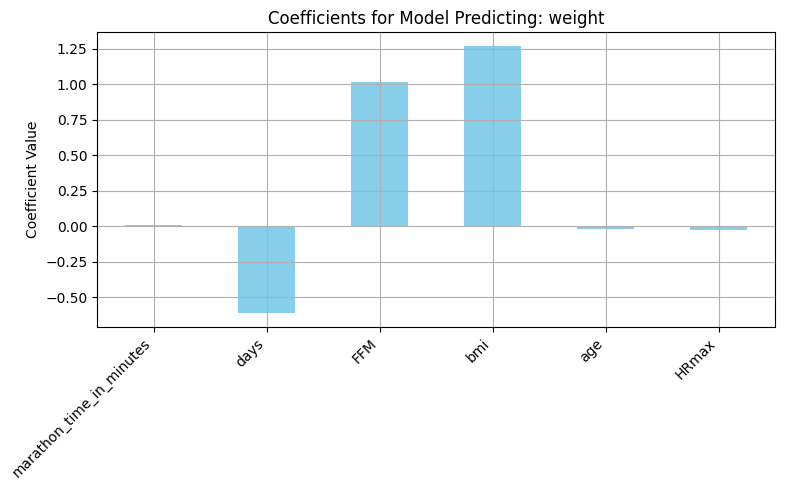

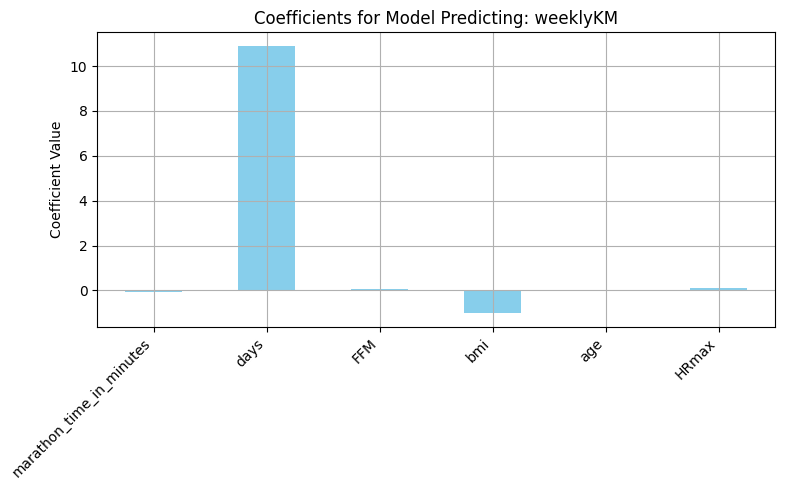

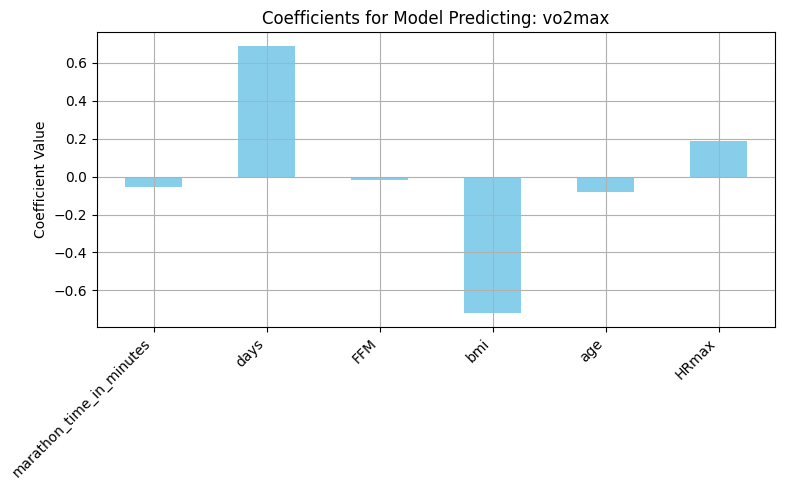

In [ ]:
for target_name, model in zip(y_marathon.columns, models_seed_20):

    coef = model.params.drop(labels='Intercept', errors='ignore')

    plt.figure(figsize=(8, 5))
    coef.plot(kind='bar', color='skyblue')
    plt.title(f"Coefficients for Model Predicting: {target_name}")
    plt.ylabel("Coefficient Value")
    plt.xticks(rotation=45, ha='right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

#### __WEIGHTS FOR SEED=35__

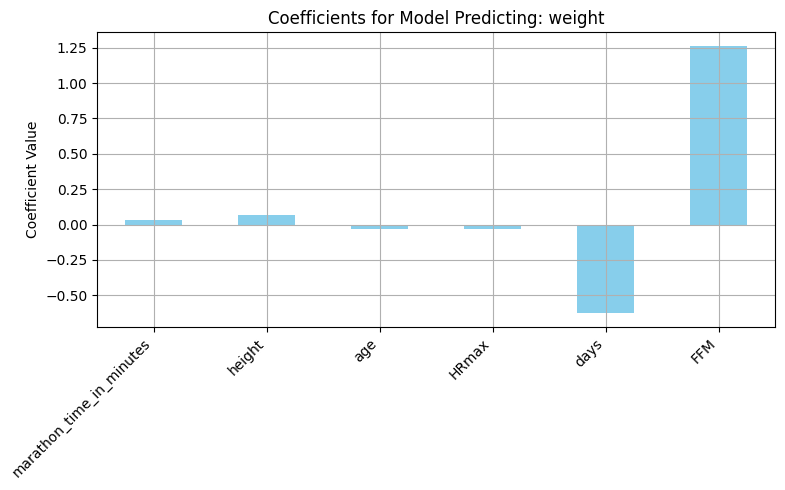

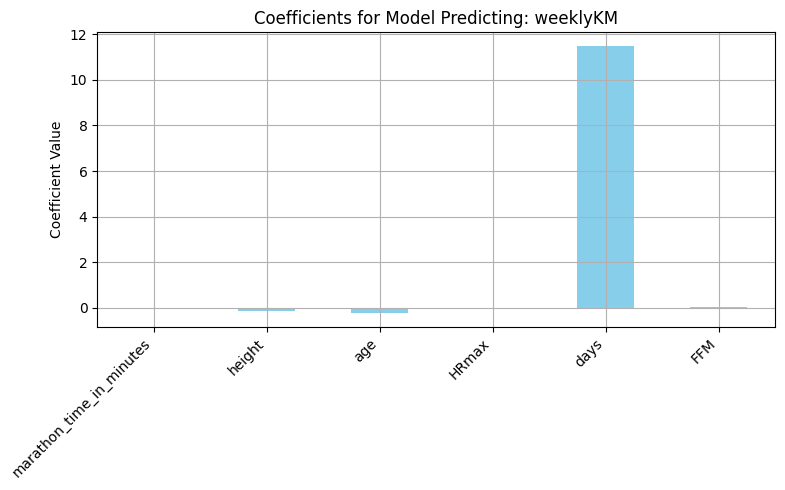

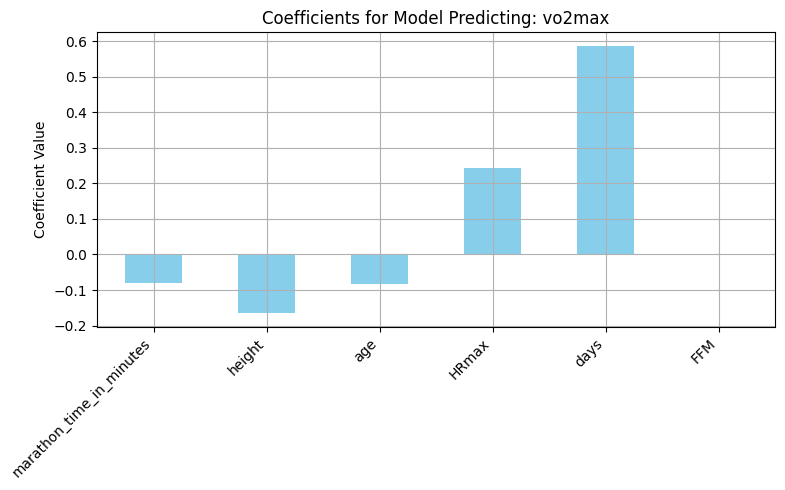

In [ ]:
for target_name, model in zip(y_marathon.columns, models_seed_35):

    coef = model.params.drop(labels='Intercept', errors='ignore')

    plt.figure(figsize=(8, 5))
    coef.plot(kind='bar', color='skyblue')
    plt.title(f"Coefficients for Model Predicting: {target_name}")
    plt.ylabel("Coefficient Value")
    plt.xticks(rotation=45, ha='right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## __*LASSO LINEAR REGRESSION*__

In [86]:
X = data[['marathon_time_in_minutes', 'height', 'age', 'HRmax', 'days', 'weight']]
y = data[['vo2max', 'weeklyKM']]

In [ ]:
def run_normal_lasso(seed):

    y_vo = data[['vo2max']]
    y_weekly = data[['weeklyKM']]

    X_tmp_vo, X_test_vo, y_tmp_vo, y_test_vo = train_test_split(X, y_vo, test_size=0.2, random_state=seed)
    X_train_vo, X_validation_vo, y_train_vo, y_validation_vo = train_test_split(X_tmp_vo, y_tmp_vo, test_size=0.125, random_state=seed)


    X_tmp_weekly, X_test_weekly, y_tmp_weekly, y_test_weekly = train_test_split(X, y_weekly, test_size=0.2, random_state=seed)
    X_train_weekly, X_validation_weekly, y_train_weekly, y_validation_weekly = train_test_split(X_tmp_weekly, y_tmp_weekly, test_size=0.125, random_state=seed)

    # ************************************************************************************************************
    # VO2MAX

    # NOTE standardize data !!
    scaler_vo = StandardScaler()
    X_train_scaled_vo = scaler_vo.fit_transform(X_train_vo)
    X_validation_scaled_vo = scaler_vo.transform(X_validation_vo)
    X_test_scaled_vo = scaler_vo.transform(X_test_vo)

    # NOTE: we can scale only X and not y because this way the model learns how to predict the y correctly as unscaled ones.
    lasso_vo = Lasso(alpha=1.0)
    lasso_vo.fit(X_train_scaled_vo, y_train_vo)

    y_pred_vo = lasso_vo.predict(X_validation_scaled_vo)

    # NOTE per output r2
    r2 = r2_score(y_validation_vo, y_pred_vo, multioutput='raw_values')  
    print("R² scores :", r2)

    print("Lasso coefficients:", lasso_vo.coef_,)
    print("*"*200)

    y_test_pred_vo = lasso_vo.predict(X_test_scaled_vo)
    r2_test_vo = r2_score(y_test_vo, y_test_pred_vo)
    print("Test R² score:", r2_test_vo)

    # ************************************************************************************************************
    # WEELYKM

    scaler_weekly = StandardScaler()
    X_train_scaled_weekly = scaler_weekly.fit_transform(X_train_weekly)
    X_validation_scaled_weekly = scaler_weekly.transform(X_validation_weekly)
    X_test_scaled_weekly = scaler_weekly.transform(X_test_weekly)

    lasso_weekly = Lasso(alpha=1.0)
    lasso_weekly.fit(X_train_scaled_weekly, y_train_weekly)

    y_pred_weekly = lasso_weekly.predict(X_validation_scaled_weekly)

    r2 = r2_score(y_validation_weekly, y_pred_weekly, multioutput='raw_values')  
    print("R² scores :", r2)

    print("Lasso coefficients:", lasso_weekly.coef_)
    print("*"*200)

    lasso_weekly.predict(X_test_weekly)

    y_test_pred_weekly = lasso_weekly.predict(X_test_scaled_weekly)
    r2_test_weekly = r2_score(y_test_weekly, y_test_pred_weekly)
    print("Test R² score:", r2_test_weekly)

    return [lasso_vo,lasso_weekly]

In [88]:
lasso_42 = run_normal_lasso(42)
lasso_20 = run_normal_lasso(20)
lasso_35 = run_normal_lasso(35)

R² scores : [0.52586133]
Lasso coefficients: [-2.22306203 -0.         -0.63454231  1.53101348  0.         -0.75647673]
********************************************************************************************************************************************************************************************************
Test R² score: 0.3830013557153804
R² scores : [0.63216455]
Lasso coefficients: [-4.00557798  0.          0.         -0.         12.06749971 -1.74066837]
********************************************************************************************************************************************************************************************************
Test R² score: 0.45762361311305644
R² scores : [0.70346595]
Lasso coefficients: [-1.95842227 -0.         -0.66678049  1.19152315  0.         -1.89557185]
****************************************************************************************************************************************************************************

/home/lamberto/.local/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but Lasso was fitted without feature names
  warnings.warn(
/home/lamberto/.local/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but Lasso was fitted without feature names
  warnings.warn(
/home/lamberto/.local/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but Lasso was fitted without feature names
  warnings.warn(


### __Coefficients__

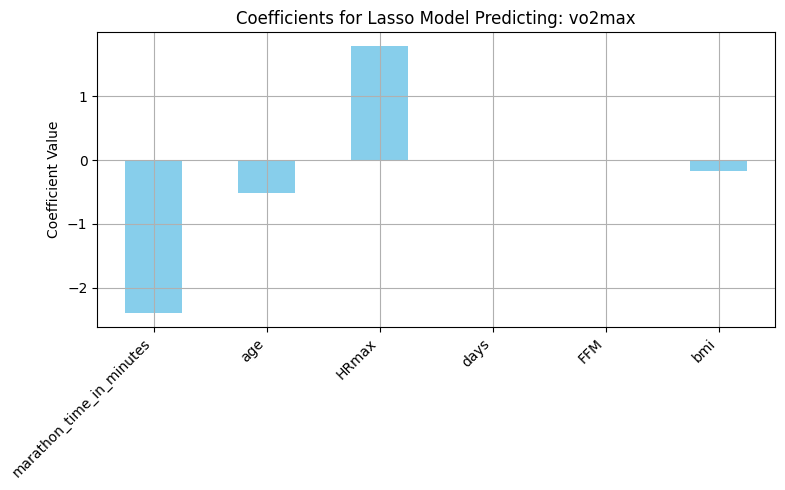

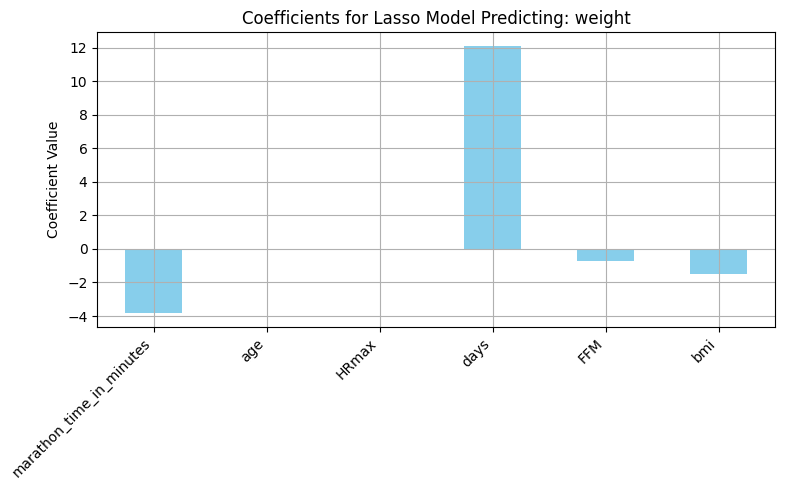

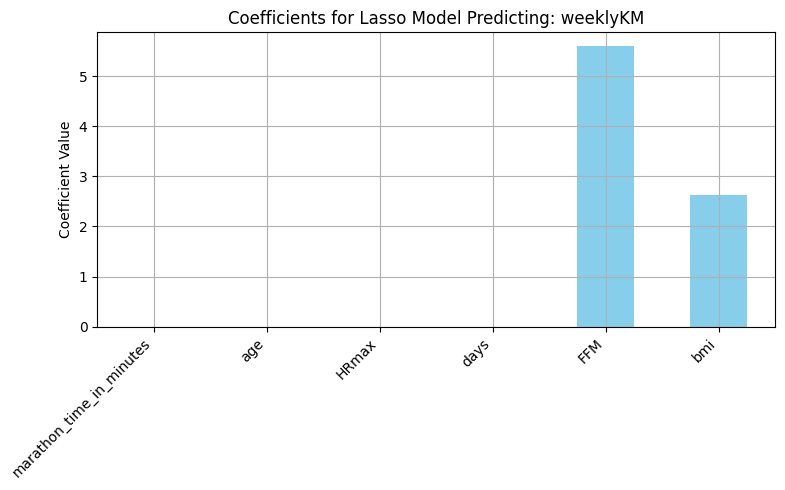

In [ ]:
for target_name, model in zip(y.columns, lasso_42):
    # Convert to pandas Series with feature names
    coef = pd.Series(model.coef_, index=X.columns)

    plt.figure(figsize=(8, 5))
    coef.plot(kind='bar', color='skyblue')
    plt.title(f"Coefficients for Lasso Model Predicting: {target_name}")
    plt.ylabel("Coefficient Value")
    plt.xticks(rotation=45, ha='right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

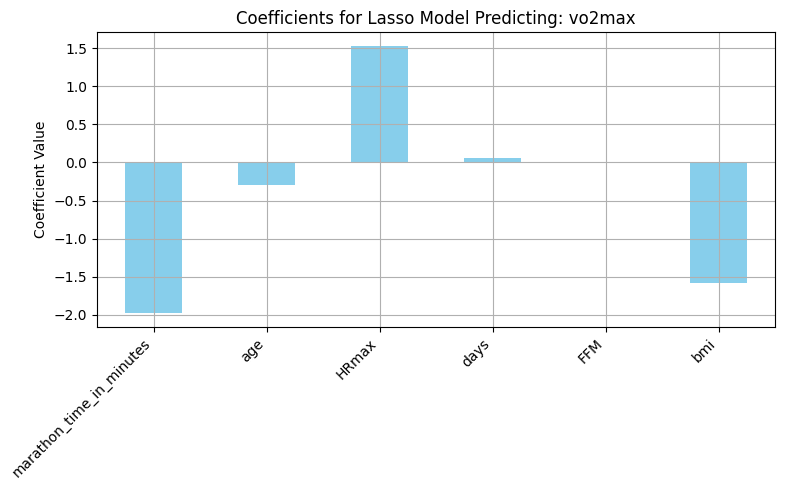

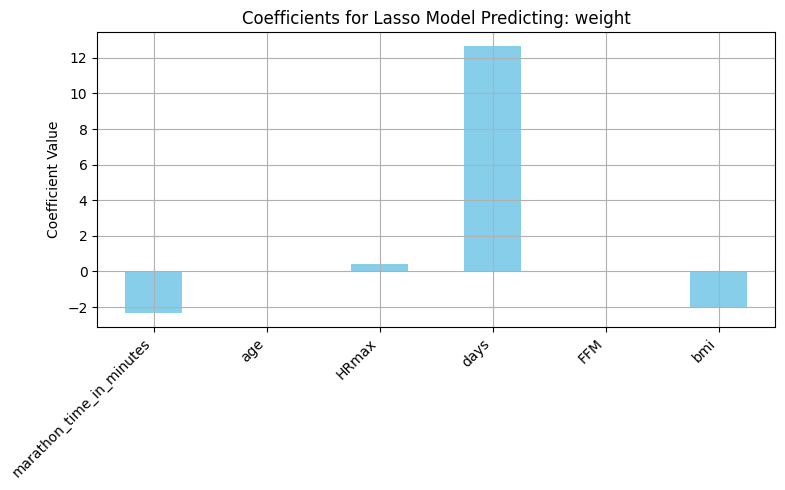

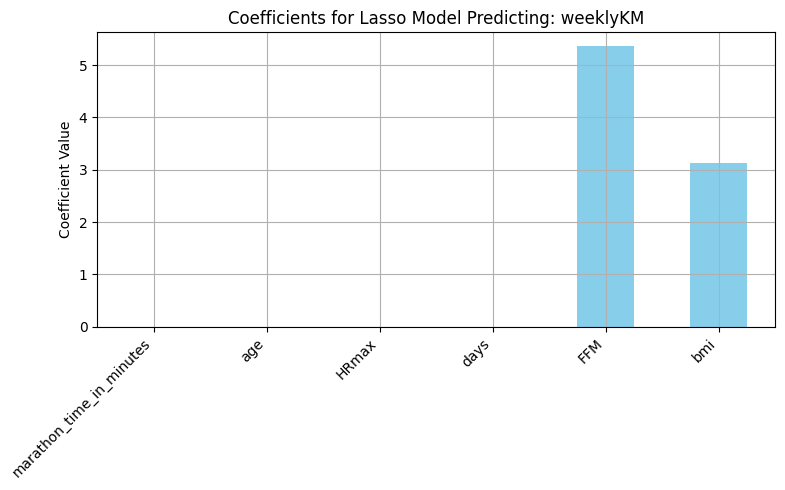

In [ ]:
for target_name, model in zip(y.columns, lasso_20):
    # Convert to pandas Series with feature names
    coef = pd.Series(model.coef_, index=X.columns)

    plt.figure(figsize=(8, 5))
    coef.plot(kind='bar', color='skyblue')
    plt.title(f"Coefficients for Lasso Model Predicting: {target_name}")
    plt.ylabel("Coefficient Value")
    plt.xticks(rotation=45, ha='right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

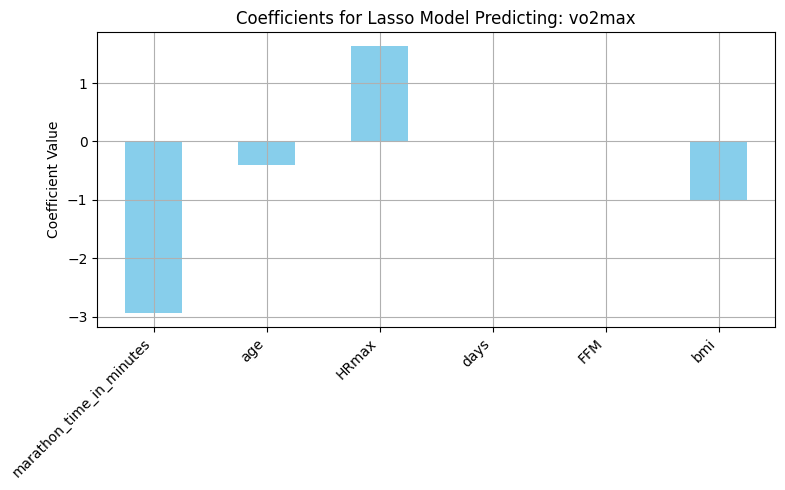

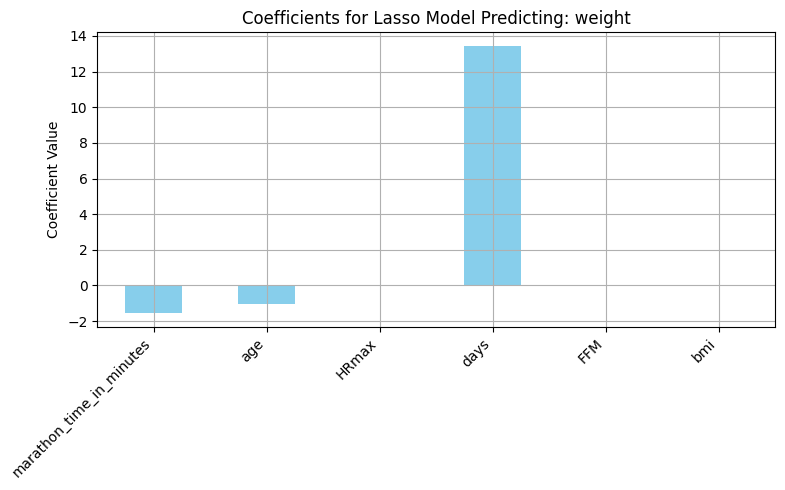

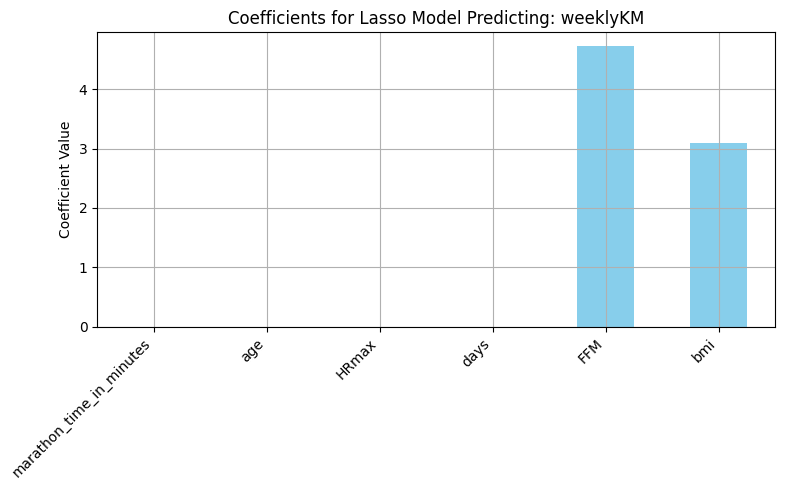

In [ ]:
for target_name, model in zip(y.columns, lasso_35):
    # Convert to pandas Series with feature names
    coef = pd.Series(model.coef_, index=X.columns)

    plt.figure(figsize=(8, 5))
    coef.plot(kind='bar', color='skyblue')
    plt.title(f"Coefficients for Lasso Model Predicting: {target_name}")
    plt.ylabel("Coefficient Value")
    plt.xticks(rotation=45, ha='right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

### __LASSOCV MODEL__

Tunes alpha because of CrossValidation and fits a separate lasso for each element of the Multioutput regressor!!

In [94]:
def run_lassoCV(X,y,seed):
    X_tmp, X_test, y_tmp, y_test = train_test_split(X,y, test_size=0.2, random_state=seed)

    # NOTE: now the 100% of data here is just 80% of total
    X_train, X_validation, y_train, y_validation= train_test_split(X_tmp,y_tmp, test_size=0.125, random_state=seed)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    base_lasso = LassoCV(cv=5, random_state=42)
    multi_lasso = MultiOutputRegressor(base_lasso)

    multi_lasso.fit(X_train_scaled, y_train)
    y_pred = multi_lasso.predict(X_test_scaled)
    
    print('*'*200)
    # NOTE per output r2
    r2 = r2_score(y_test, y_pred, multioutput='raw_values')  
    print("Test R² scores per target:", r2)

    # NOTE single r2
    r2_mean = r2_score(y_test, y_pred)
    print("Test Mean R² score:", r2_mean)

    for i, estimator in enumerate(multi_lasso.estimators_):
        print(f"Target {y.columns[i]} coefficients:\n", estimator.coef_)

    print('*'*200)

    return multi_lasso,r2_mean

In [95]:
lassocv_42,r2_42 = run_lassoCV(X,y,42)
lassocv_20,r2_20 = run_lassoCV(X,y,20)
lassocv_35,r2_35 = run_lassoCV(X,y,35)

********************************************************************************************************************************************************************************************************
Test R² scores per target: [0.4242387  0.45832589]
Test Mean R² score: 0.44128229540948294
Target vo2max coefficients:
 [-2.50844865 -0.09047593 -0.93018052  1.72269002  0.06972556 -0.97579381]
Target weeklyKM coefficients:
 [-4.07990108  0.          0.         -0.         12.16880943 -1.86008969]
********************************************************************************************************************************************************************************************************
********************************************************************************************************************************************************************************************************
Test R² scores per target: [0.39508491 0.69214298]
Test Mean R² score: 0.5436139454355917
Target v

### __COEFFICIENTS__

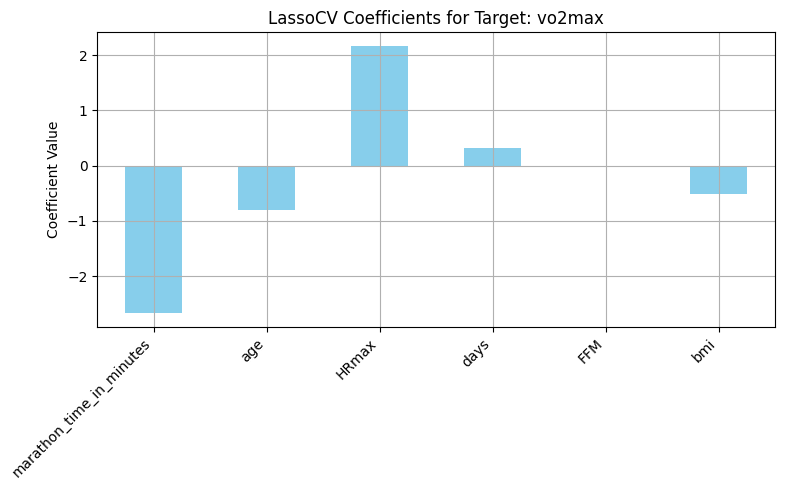

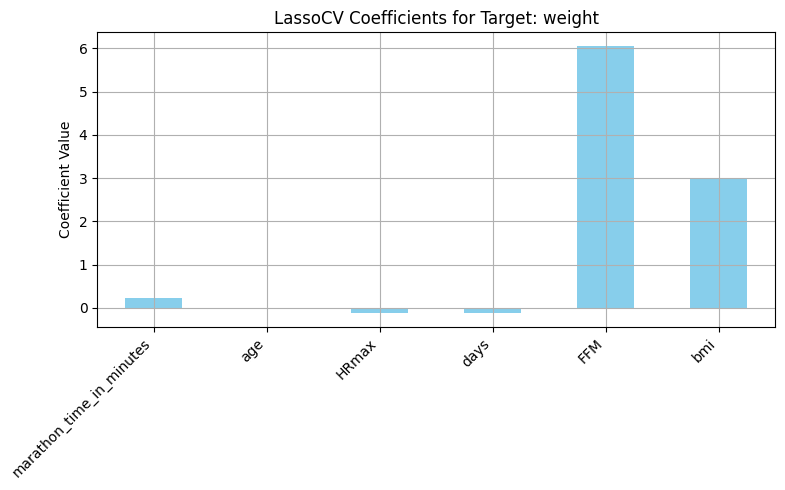

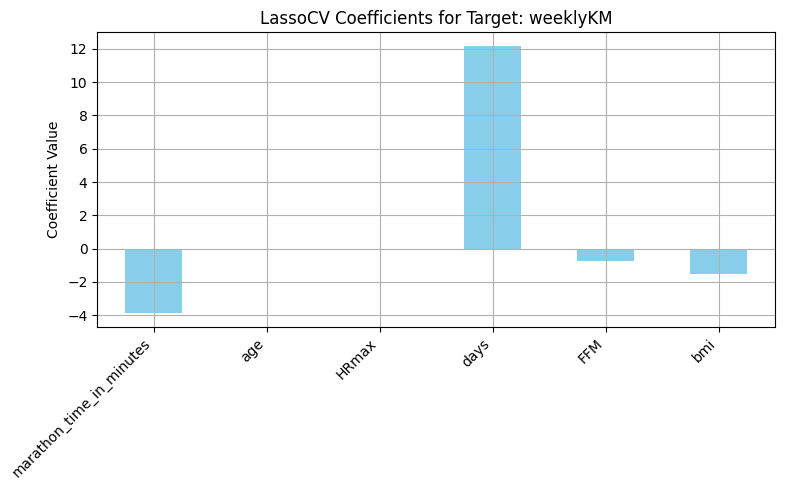

In [ ]:
for target_name, estimator in zip(y.columns, lassocv_42.estimators_):
    coef = pd.Series(estimator.coef_, index=X.columns)

    plt.figure(figsize=(8, 5))
    coef.plot(kind='bar', color='skyblue')
    plt.title(f"LassoCV Coefficients for Target: {target_name}")
    plt.ylabel("Coefficient Value")
    plt.xticks(rotation=45, ha='right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

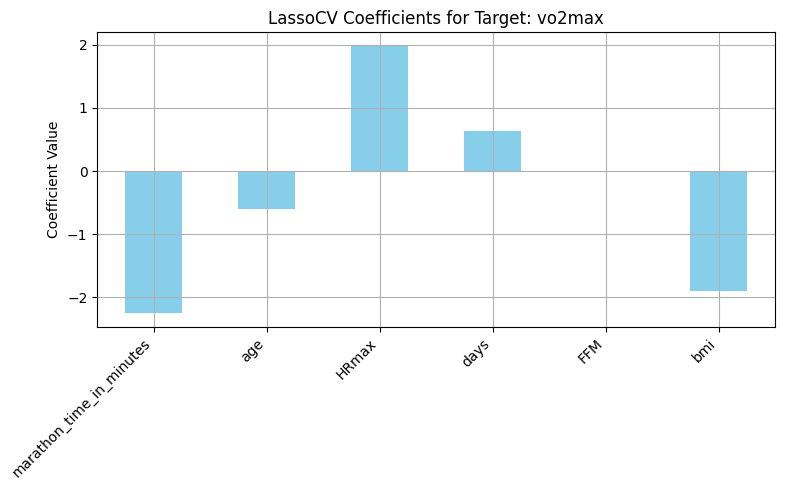

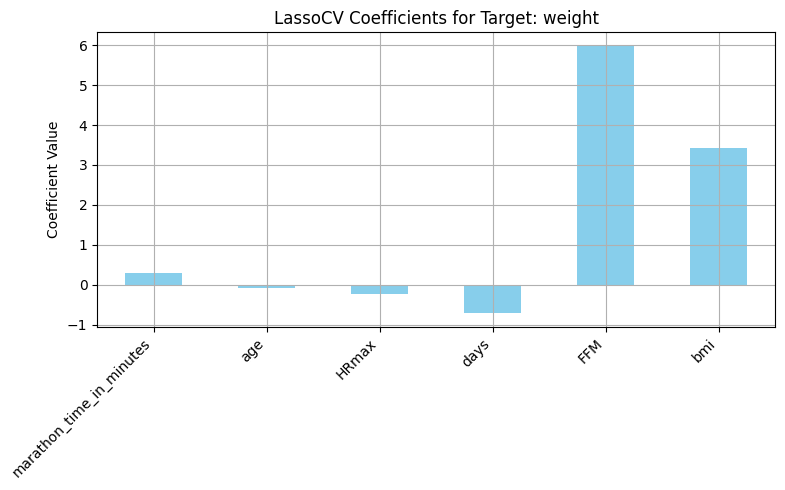

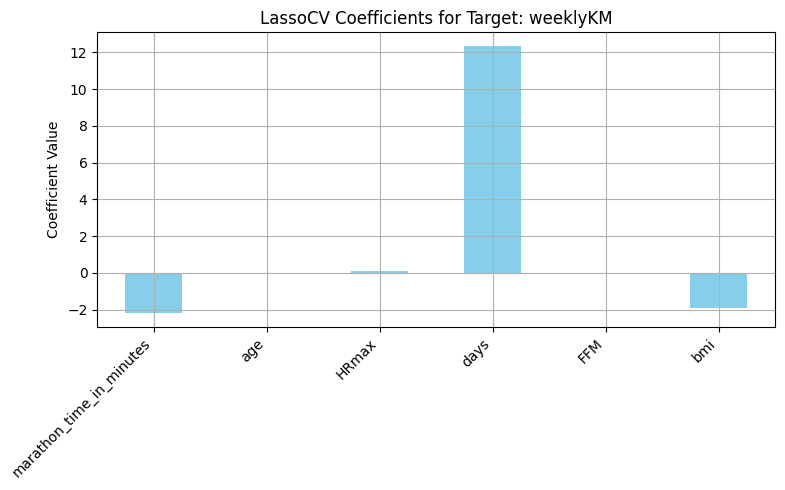

In [ ]:
for target_name, estimator in zip(y.columns, lassocv_20.estimators_):
    coef = pd.Series(estimator.coef_, index=X.columns)

    plt.figure(figsize=(8, 5))
    coef.plot(kind='bar', color='skyblue')
    plt.title(f"LassoCV Coefficients for Target: {target_name}")
    plt.ylabel("Coefficient Value")
    plt.xticks(rotation=45, ha='right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

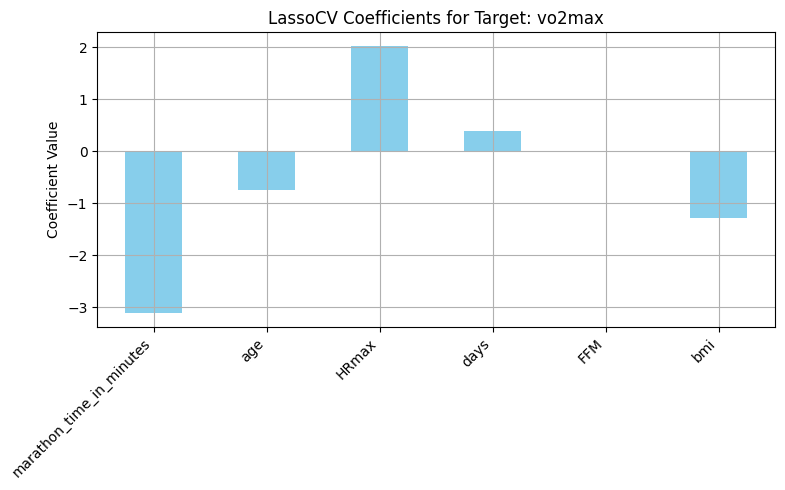

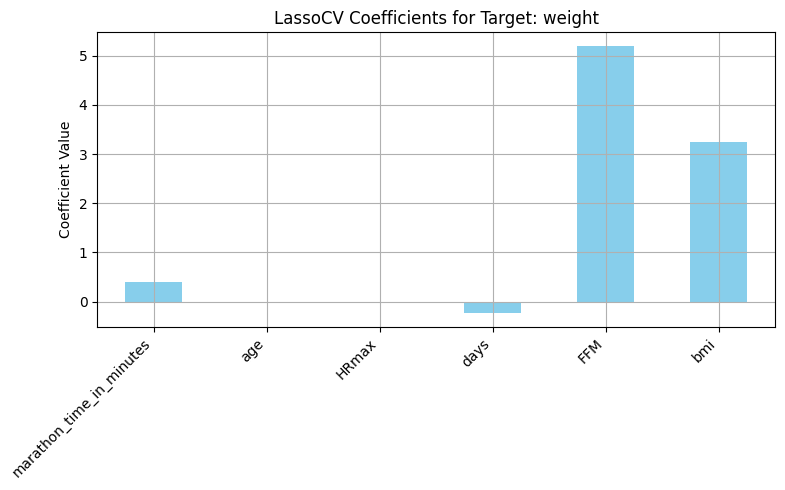

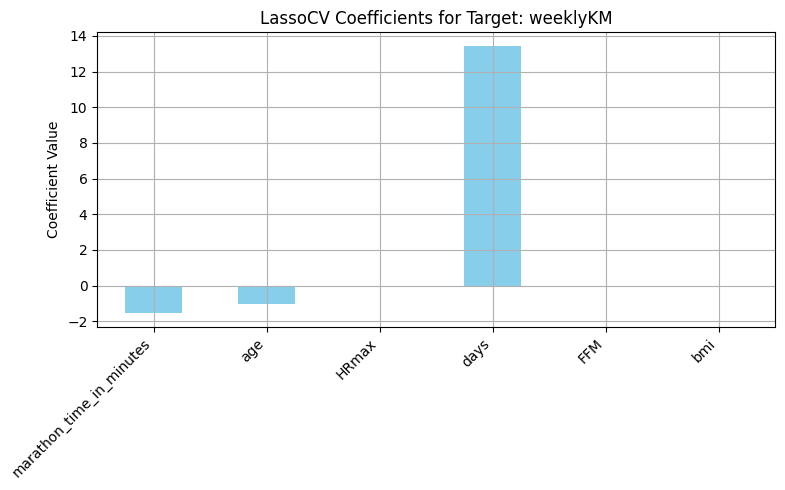

In [ ]:
for target_name, estimator in zip(y.columns, lassocv_35.estimators_):
    coef = pd.Series(estimator.coef_, index=X.columns)

    plt.figure(figsize=(8, 5))
    coef.plot(kind='bar', color='skyblue')
    plt.title(f"LassoCV Coefficients for Target: {target_name}")
    plt.ylabel("Coefficient Value")
    plt.xticks(rotation=45, ha='right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## __*CALORIES*__

In [ ]:
calories = pd.read_csv('cardioActivities.csv')
calories.isnull().sum()

Date                          0
Activity Id                   0
Type                          0
Route Name                  507
Distance (km)                 0
Duration                      0
Average Pace                  0
Average Speed (km/h)          0
Calories Burned               0
Climb (m)                     0
Average Heart Rate (bpm)    214
Friend's Tagged             508
Notes                       277
GPX File                      4
dtype: int64

In [ ]:
calories.head()

,Date,Activity Id,Type,Route Name,Distance (km),Duration,Average Pace,Average Speed (km/h),Calories Burned,Climb (m),Average Heart Rate (bpm),Friend's Tagged,Notes,GPX File
0,2018-11-11 14:05:12,c9627fed-14ac-47a2-bed3-2a2630c63c15,Running,NaN,10.44,58:40,5:37,10.68,774.0,130,159.0,NaN,NaN,2018-11-11-140512.gpx
1,2018-11-09 15:02:35,be65818d-a801-4847-a43b-2acdf4dc70e7,Running,NaN,12.84,1:14:12,5:47,10.39,954.0,168,159.0,NaN,NaN,2018-11-09-150235.gpx
2,2018-11-04 16:05:00,c09b2f92-f855-497c-b624-c196b3ef036c,Running,NaN,13.01,1:15:16,5:47,10.37,967.0,171,155.0,NaN,NaN,2018-11-04-160500.gpx
3,2018-11-01 14:03:58,bc9b612d-3499-43ff-b82a-9b17b71b8a36,Running,NaN,12.98,1:14:25,5:44,10.47,960.0,169,158.0,NaN,NaN,2018-11-01-140358.gpx
4,2018-10-27 17:01:36,972567b2-1b0e-437c-9e82-fef8078d6438,Running,NaN,13.02,1:12:50,5:36,10.73,967.0,170,154.0,NaN,NaN,2018-10-27-170136.gpx


In [ ]:
print(calories['Type'].unique())

['Running' 'Cycling' 'Other' 'Walking']


In [ ]:
calories = calories[calories['Type'] == 'Running']

In [ ]:
print(calories['Type'].unique())

['Running']


In [ ]:
calories = calories.drop(columns=['Route Name', "Friend's Tagged", 'Date', 'Activity Id', 'Notes', 'GPX File'])
calories = calories.dropna(subset=['Average Heart Rate (bpm)',])
calories.isnull().sum()

Type                        0
Distance (km)               0
Duration                    0
Average Pace                0
Average Speed (km/h)        0
Calories Burned             0
Climb (m)                   0
Average Heart Rate (bpm)    0
dtype: int64

In [ ]:
def time_to_minutes(time_str):
    if pd.isna(time_str):
        return pd.NA 
    t = time_str.split(':')
    return int(t[0]) * 60 + int(t[1])

# NOTE: kept in minutes, trimmed seconds
calories['Duration'] = calories['Duration'].apply(time_to_minutes)
calories['Average Pace'] = calories['Average Pace'].str.replace(':', '.').astype(float, errors='ignore')
calories.head()

,Type,Distance (km),Duration,Average Pace,Average Speed (km/h),Calories Burned,Climb (m),Average Heart Rate (bpm)
0,Running,10.44,3520,5.37,10.68,774.0,130,159.0
1,Running,12.84,74,5.47,10.39,954.0,168,159.0
2,Running,13.01,75,5.47,10.37,967.0,171,155.0
3,Running,12.98,74,5.44,10.47,960.0,169,158.0
4,Running,13.02,72,5.36,10.73,967.0,170,154.0


In [ ]:
print(calories.dtypes)

Type                         object
Distance (km)               float64
Duration                      int64
Average Pace                float64
Average Speed (km/h)        float64
Calories Burned             float64
Climb (m)                     int64
Average Heart Rate (bpm)    float64
dtype: object


In [ ]:
calories = calories.rename(columns={
    'Distance (km)': 'Distance',
    'Duration': 'Time',
    'Average Heart Rate (bpm)': 'HeartRate',
    'Average Pace': 'Pace',
    'Calories Burned': 'Calories'
})

calories.head()

,Type,Distance,Time,Pace,Average Speed (km/h),Calories,Climb (m),HeartRate
0,Running,10.44,3520,5.37,10.68,774.0,130,159.0
1,Running,12.84,74,5.47,10.39,954.0,168,159.0
2,Running,13.01,75,5.47,10.37,967.0,171,155.0
3,Running,12.98,74,5.44,10.47,960.0,169,158.0
4,Running,13.02,72,5.36,10.73,967.0,170,154.0


In [ ]:
data_ols_calories = calories[['Distance', 'Pace', 'Calories']]

train, test = train_test_split(data_ols_calories, test_size=0.3, random_state=42)

model_calories = smf.ols(f" Calories ~ Distance + Pace ", data=train).fit()


In [ ]:
print(model_calories.summary())   

                            OLS Regression Results                            
Dep. Variable:               Calories   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                 1.814e+04
Date:                Tue, 06 May 2025   Prob (F-statistic):          1.28e-217
Time:                        16:06:47   Log-Likelihood:                -884.21
No. Observations:                 193   AIC:                             1774.
Df Residuals:                     190   BIC:                             1784.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -92.3571     30.551     -3.023      0.0

__*CALCULATE INTERVALS*__

In [ ]:

# NOTE create arrays
weight= np.array([weight_r_42,weight_r_35,weight_r_20])
weeklyKM= np.array([weeklyKM_r_42,weeklyKM_r_35,weeklyKM_r_20])
vo2max= np.array([vo2max_r_42,vo2max_r_35,vo2max_r_20]) 

weight_mean = np.mean(weight)
weeklyKM_mean = np.mean(weeklyKM)
vo2max_mean = np.mean(vo2max)

# NOTE calculate stdev
weight_std = np.std(weight)
weeklyKM_std = np.std(weeklyKM)
vo2max_std = np.std(vo2max)

weight_interval = (weight_mean - weight_std, weight_mean + weight_std)
weeklyKM_interval = (weeklyKM_mean - weeklyKM_std, weeklyKM_mean + weeklyKM_std)
vo2max_interval = (vo2max_mean - vo2max_std, vo2max_mean + vo2max_std)

print(f"Weight interval:   {weight_interval[0]:.2f} to {weight_interval[1]:.2f}")
print(f"WeeklyKM interval: {weeklyKM_interval[0]:.2f} to {weeklyKM_interval[1]:.2f}")
print(f"VO2Max interval:   {vo2max_interval[0]:.2f} to {vo2max_interval[1]:.2f}")

Weight interval:   0.85 to 0.89
WeeklyKM interval: 0.45 to 0.61
VO2Max interval:   0.36 to 0.48


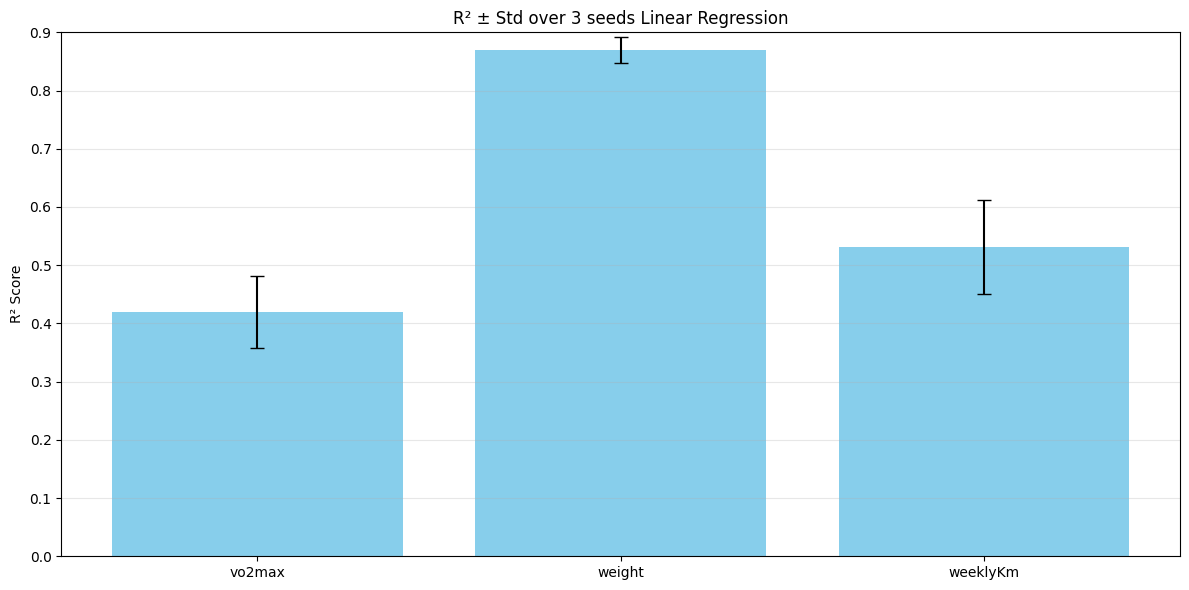

In [ ]:
metrics = ['vo2max', 'weight', 'weeklyKm']
r2_means = [vo2max_mean, weight_mean, weeklyKM_mean]
r2_stds = [ vo2max_std,weight_std, weeklyKM_std]

plt.figure(figsize=(12,6))
plt.bar(metrics, r2_means, yerr=r2_stds, capsize=5, color='skyblue')
plt.ylabel('R² Score')
plt.title('R² ± Std over 3 seeds Linear Regression')
plt.grid(axis='y', alpha=0.3)
plt.ylim(0, 0.9)
plt.tight_layout()
plt.show()

## __GRAPH FOR THE REPORT -- MODEL COMPARISON__

In [106]:
linear_42 = (vo2max_r_42 + weeklyKM_r_42) / 2
linear_35 = (vo2max_r_20 + weeklyKM_r_20) / 2
linear_20 = (vo2max_r_35 + weeklyKM_r_35) / 2

linear_arr = np.array([linear_42, linear_20, linear_35])

linear_mean = np.mean(linear_arr)
linear_std = np.std(linear_arr)

print(f"mean: {linear_mean}, std dev : {linear_std}, up interval : {linear_mean + linear_std}, low interval : {linear_mean - linear_std}")

mean: 0.4821169655439463, std dev : 0.05378290790805116, up interval : 0.5358998734519974, low interval : 0.4283340576358951


In [107]:
lasso_arr = np.array([r2_42,r2_20,r2_35])

lasso_mean = np.mean(lasso_arr)
lasso_std = np.std(lasso_arr)

print(f"mean: {lasso_mean}, std dev : {lasso_std}, up interval : {lasso_mean + lasso_std}, low interval : {lasso_mean - lasso_std}")

mean: 0.48102283611806856, std dev : 0.04479250691488716, up interval : 0.5258153430329557, low interval : 0.4362303292031814


In [108]:
extra_42 = 0.4198
extra_20 = 0.4867 
extra_35 = 0.4651

extra_arr = np.array([extra_42,extra_20,extra_35])
extra_mean = np.mean(extra_arr)
extra_std = np.std(extra_arr)

print(f"mean: {extra_mean}, std dev : {extra_std}, up interval : {extra_mean + extra_std}, low interval : {extra_mean - extra_std}")

mean: 0.45720000000000005, std dev : 0.027877230852435833, up interval : 0.48507723085243587, low interval : 0.42932276914756423


In [109]:
mlp_42 = 0.44042956829071045
mlp_20 = 0.5795910954475403
mlp_35 = 0.5038080215454102

mlp_arr = np.array([mlp_42,mlp_20,mlp_35])
mlp_mean = np.mean(mlp_arr)
mlp_std = np.std(mlp_arr)

print(f"mean: {mlp_mean}, std dev : {mlp_std}, up interval : {mlp_mean + mlp_std}, low interval : {mlp_mean - mlp_std}")

mean: 0.5079428950945536, std dev : 0.056887640981182236, up interval : 0.5648305360757359, low interval : 0.45105525411337133


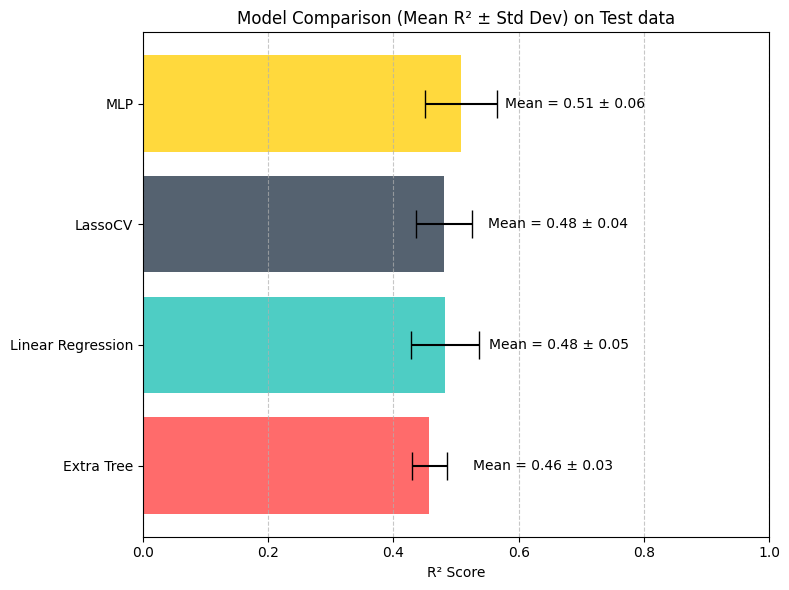

In [124]:
import matplotlib.pyplot as plt
import numpy as np

models = ['Extra Tree', 'Linear Regression', 'LassoCV', 'MLP']
means = [extra_mean, linear_mean, lasso_mean, mlp_mean]  # your mean R² values
stds = [extra_std, linear_std, lasso_std, mlp_std]       # your std dev values

colors = ["#FF6B6B", "#4ECDC4", "#556270", "#FFD93D"]

plt.figure(figsize=(8, 6))
bars = plt.barh(models, means, xerr=stds, capsize=10, color=colors)

plt.xlabel('R² Score')
plt.title('Model Comparison (Mean R² ± Std Dev) on Test data')
plt.xlim(0, 1)  # Adjust depending on your R² range
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Annotate bars with mean values
for bar, mean, std in zip(bars, means, stds):
    width = bar.get_width()
    plt.text(width + 0.07, bar.get_y() + bar.get_height() / 2, f"Mean = {mean:.2f} ± {std:.2f}", va='center')

plt.tight_layout()
plt.show()
